In [1]:
import os
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from src.dataimport import list_files_with_extension_directory, load_text
from src.llmlib import num_tokens_from_string

# Loading Files

In [2]:
TXT_FILES_PATH = 'data/original/brat-project-final/'
JSON_FILES_PATH = 'data/transformed/'

txt_files_directory_list = list_files_with_extension_directory(TXT_FILES_PATH, '.txt')

json_files_directory_list = list_files_with_extension_directory(JSON_FILES_PATH, '.json')

In [3]:
df = pd.DataFrame()
df['txt_path'] = txt_files_directory_list
df['json_path'] = json_files_directory_list
df['txt_file'] = df['txt_path'].apply(lambda x: os.path.basename(x))
df['json_file'] = df['json_path'].apply(lambda x: os.path.basename(x))
df['txt'] = df['txt_path'].apply(load_text)
df['json'] = df['json_path'].apply(load_text)

print(df.shape)
df.head()

(402, 6)


,txt_path,json_path,txt_file,json_file,txt,json
0,data/original/brat-project-final/essay001.txt,data/transformed/essay001.json,essay001.txt,essay001.json,Should students be taught to compete or to coo...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
1,data/original/brat-project-final/essay002.txt,data/transformed/essay002.json,essay002.txt,essay002.json,More people are migrating to other countries t...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
2,data/original/brat-project-final/essay003.txt,data/transformed/essay003.json,essay003.txt,essay003.json,International tourism is now more common than ...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
3,data/original/brat-project-final/essay004.txt,data/transformed/essay004.json,essay004.txt,essay004.json,International tourism is now more common than ...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
4,data/original/brat-project-final/essay005.txt,data/transformed/essay005.json,essay005.txt,essay005.json,Living and studying overseas\n\nIt is every st...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."


# Train-Test Split

In [4]:
# Split the dataframe into training and test sets
train_df, test_df = train_test_split(df, train_size=40, random_state=42)

# Display the first few rows of the training and test sets
print(f"Training DataFrame: {train_df.shape}")
print(f"\nTest DataFrame: {test_df.shape}")

Training DataFrame: (40, 6)

Test DataFrame: (362, 6)


In [5]:
train_df = train_df.sort_values(by='txt_file')
train_df.head()

,txt_path,json_path,txt_file,json_file,txt,json
20,data/original/brat-project-final/essay021.txt,data/transformed/essay021.json,essay021.txt,essay021.json,Advertisements affects on consumer goods\n\nEv...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
21,data/original/brat-project-final/essay022.txt,data/transformed/essay022.json,essay022.txt,essay022.json,Young people should go to university or not\n\...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
48,data/original/brat-project-final/essay049.txt,data/transformed/essay049.json,essay049.txt,essay049.json,Do modern communication technologies benefit a...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
50,data/original/brat-project-final/essay051.txt,data/transformed/essay051.json,essay051.txt,essay051.json,Universities should give money to sport activi...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
54,data/original/brat-project-final/essay055.txt,data/transformed/essay055.json,essay055.txt,essay055.json,Should teenagers learn all school subjects/foc...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."


In [6]:
test_df = test_df.sort_values(by='txt_file')
test_df.head()

,txt_path,json_path,txt_file,json_file,txt,json
0,data/original/brat-project-final/essay001.txt,data/transformed/essay001.json,essay001.txt,essay001.json,Should students be taught to compete or to coo...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
1,data/original/brat-project-final/essay002.txt,data/transformed/essay002.json,essay002.txt,essay002.json,More people are migrating to other countries t...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
2,data/original/brat-project-final/essay003.txt,data/transformed/essay003.json,essay003.txt,essay003.json,International tourism is now more common than ...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
3,data/original/brat-project-final/essay004.txt,data/transformed/essay004.json,essay004.txt,essay004.json,International tourism is now more common than ...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
4,data/original/brat-project-final/essay005.txt,data/transformed/essay005.json,essay005.txt,essay005.json,Living and studying overseas\n\nIt is every st...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."


# Daten aufbereiten

## Grundwahrheit
aus Testdatensatz

In [7]:
def replace_ids_with_sentences(data):
    """
    Ersetzt die IDs in den argumentativen Beziehungen durch die entsprechenden Texte aus den Major Claims, Claims und Premises. 
    Zur Anwendung auf einen Pandas Dataframe.
    Args:
        data (dict): Dictionary aus den JSON-Dateien mit den Argumentationskomponenten und -beziehungen
    Returns:
        list: Liste von Dictionaries mit den Argumentativen Beziehungen, wobei die IDs durch die entsprechenden Texte ersetzt wurden
    """
    # Create dictionaries to map IDs to sentences
    major_claims = {mc['ID']: mc['Text'] for mc in data['MajorClaims']}
    claims = {c['ID']: c['Text'] for c in data['Claims']}
    premises = {p['ID']: p['Text'] for p in data['Premises']}

    transformed_relations = []
    # Aus den Beziehungen die Origin und Target IDs entnehmen 
    for relation in data['ArgumentativeRelations']:
        origin_id = relation['Origin']
        target_id = relation['Target']
        # Wenn die ID in den Major Claims (Dict) enthalten ist, dann den Text ausgeben
        if origin_id in major_claims:
            origin_text = major_claims[origin_id]
        # Wenn die ID in den Claims (Dict) enthalten ist, dann den Text ausgeben
        elif origin_id in claims:
            origin_text = claims[origin_id]
        # Wenn die ID in den Premises (Dict) enthalten ist, dann den Text ausgeben
        elif origin_id in premises:
            origin_text = premises[origin_id]
        # Wenn die ID nicht in den Major Claims, Claims oder Premises enthalten ist, dann die ID ausgeben
        else:
            origin_text = origin_id

        # Wie zuvor, nur mit der TargetID
        if target_id in major_claims:
            target_text = major_claims[target_id]
        elif target_id in claims:
            target_text = claims[target_id]
        elif target_id in premises:
            target_text = premises[target_id]
        else:
            target_text = target_id # Notwendig, da bei Beziehungen zu MajorClaims nicht definiert wird um welchen MajorClaim es sich handelt. 

        # Die Beziehungen mit den durch Texten ersetzten IDs in ein neues Dictionary schreiben
        transformed_relations.append({
            'Origin': origin_text, 
            'Relation': relation['Relation'], # Relation bleibt gleich
            'Target': target_text
        })

    return transformed_relations


def extract_relations(list_of_dicts):
    """
    Extrahiert die Argumentativen Beziehungen aus einer Liste von Dictionaries und gibt sie als Liste von Tupeln zurück.
    """
    tupel = [(rel['Origin'], rel['Relation'], rel['Target']) for rel in list_of_dicts]
    return tupel


def clean_json_string(json_string):
    """
    Probiert den JSON-String in ein JSON-Objekt umzuwandeln. Sollte der JSON-String nicht korrekt bzw. vollständig sein, wird dieser bereinigt. 
    Ein JSON-String ist bspw. nicht korrekt, wenn die geschlossene Klammern fehlen. In diesem Fall wird der JSON-String bis zum letzten gültigen JSON-Objekt extrahiert.
    Das JSON-Objekt wird dann vervollständigt, indem die fehlenden Klammern hinzugefügt werden.
    Beispiel:
    JSON-String: 
    "{"ArgumentativeComponents": [{"ID": "1", "Text": "Major Claim 1"}, {"ID": "2","
    Bereinigter JSON-String:
    "{"ArgumentativeComponents": [{"ID": "1", "Text": "Major Claim 1"}]}"

    Args:
        json_string (str): JSON-String
    Returns:
        dict: JSON-Objekt
    """
    try:
        # Probiert den JSON-String in ein JSON-Objekt umzuwandeln
        json_obj = json.loads(json_string)
        return json_obj
    except json.JSONDecodeError as e: # Wenn JSON-String nicht korrekt ist (z.B. fehlende geschlossene Klammer)
        error_pos = e.pos # Position des Fehlers
        # Finde die Position des letzten gültigen JSON-Objekts. Annahme: Das letzte gültige JSON-Objekt endet mit einer geschlossenen eckigen Klammer
        last_valid_json_obj_pos = json_string.rfind("}", 0, error_pos) # rfind(value, start, end) gibt die Position des letzten Vorkommens eines Substrings zurück
        # Extrahieren des letzten gültigen JSON-Objekts anhand der Position
        last_valid_json_obj = json_string[:last_valid_json_obj_pos + 1]
        # Hinzufügen der fehlenden geschlossenen eckigen Klammer und geschlossenen geschweiften Klammer, um das JSON-Objekt zu vervollständigen
        cleaned_json_string = last_valid_json_obj + "]}"
        # Bereinigten String in JSON-Objekt umwandeln
        cleaned_json = json.loads(cleaned_json_string)
        return cleaned_json

def transform_content_to_args(df: pd.DataFrame, col_name: str):
    """
    Extrahiert aus den JSON-Objekten die Argumentkomponenten und -beziehungen. Bei den Beziehungen werden die IDs durch die entsprechenden Texte ersetzt. 
    Die Argumentkomponenten und -beziehungen werden als neue Spalten im Dataframe hinzugefügt. Die urprüngliche Spalte mit den JSON-Objekten wird gelöscht.
    
    Args:
        df (pd.DataFrame): Dataframe mit den JSON-Objekten
        col_name (str): Name der Spalte mit den JSON-Objekten

    Returns:
        pd.DataFrame: Dataframe mit den extrahierten Argumentkomponenten und -beziehungen
    """  
    df[col_name] = df[col_name].apply(clean_json_string) # Bereinigt die JSON-Strings bei Fehlern
    df['relations'] = df[col_name].apply(replace_ids_with_sentences) # Ersetzt die IDs durch die entsprechenden Texte
    df['relations'] = df['relations'].apply(extract_relations) # Extrahiert die Beziehungen als Liste von Tupeln
    # # Extrahiert die Sätze von Major Claims, Claims und Premises aus dem JSON Objekt und fügt sie als neue Spalten hinzu
    df['major_claims'] = df[col_name].apply(lambda x: [mc['Text'] for mc in x['MajorClaims']])
    df['claims'] = df[col_name].apply(lambda x: [c['Text'] for c in x['Claims']])
    df['premises'] = df[col_name].apply(lambda x: [p['Text'] for p in x['Premises']])
    df = df.drop(columns=[col_name]) # Löscht die ursprüngliche Spalte mit dem JSON Objekt
    return df    

In [8]:
# Ground Truth    
eval_df = test_df.loc[:, ['txt_file', 'json']] # selecting only the columns with the json data as the ground truth
# eval_df["json"] = eval_df["json"].apply(json.loads) # convert string to json
# eval_df["relations"] = eval_df["json"].apply(replace_ids_with_sentences) # replace IDs with sentences
# eval_df["relations"] = eval_df["relations"].apply(extract_relations) # return the relations as tuples instead of dictionaries
# # Extrahiert die Sätze aus der JSON-Datei und fügt die Texte als Liste in neue Spalten ein
# eval_df["major_claims"] = eval_df["json"].apply(lambda x: [mc['Text'] for mc in x['MajorClaims']])
# eval_df["claims"] = eval_df["json"].apply(lambda x: [c['Text'] for c in x['Claims']])
# eval_df["premises"] = eval_df["json"].apply(lambda x: [p['Text'] for p in x['Premises']])
# eval_df = eval_df.drop(columns=["json"]) # entfernen der Spalte mit den urprünglichen JSON-Daten, da diese nicht mehr benötigt werden
eval_df = transform_content_to_args(eval_df, 'json')
eval_df.head()

,txt_file,relations,major_claims,claims,premises
0,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...
1,essay002.txt,[(sustaining the cultural values of immigrants...,[they are able to sustain their cultural ident...,[sustaining the cultural values of immigrants ...,[maintaining one’s cultural identity is a key ...
2,essay003.txt,[(tourism has clearly improved lives in the to...,[it has contributed to the economic developmen...,[tourism has clearly improved lives in the tou...,[international tourism promotes many aspects o...
3,essay004.txt,[(the tourism bring large profit for the desti...,[this industry has affected the cultural attri...,[the tourism bring large profit for the destin...,[tourists from different cultures will probabl...
4,essay005.txt,[(studying at an overseas university gives ind...,[one who studies overseas will gain many skill...,[studying at an overseas university gives indi...,[Compared to the peers studying in the home co...


## Ausgaben des LLMs
JSONL-Dateien aus der Batch API.

In [9]:
JSONL_PATH = "batch_api/output/"
jsonl_files_directory_list = list_files_with_extension_directory(JSONL_PATH, '.jsonl')
jsonl_files_directory_list

['batch_api/output/one-shot.jsonl',
 'batch_api/output/output-batch-1.jsonl',
 'batch_api/output/output-batch-2.jsonl',
 'batch_api/output/output-batch-3.jsonl',
 'batch_api/output/output-batch-4.jsonl',
 'batch_api/output/zero-shot.jsonl']

In [10]:
batch_output_1 = pd.read_json("batch_api/output/output-batch-1.jsonl", lines=True)
batch_output_2 = pd.read_json("batch_api/output/output-batch-2.jsonl", lines=True)
batch_output_3 = pd.read_json("batch_api/output/output-batch-3.jsonl", lines=True)
batch_output_4 = pd.read_json("batch_api/output/output-batch-4.jsonl", lines=True)
batch_output_4.head()

,id,custom_id,response,error
0,batch_req_67838820cb908190bb1db05670129112,few-shot-20-cot_essay276.txt,"{'status_code': 200, 'request_id': '856774c31c...",NaN
1,batch_req_67838820f03c8190985d95215d91397f,few-shot-20-cot_essay278.txt,"{'status_code': 200, 'request_id': 'e2b2030fa2...",NaN
2,batch_req_6783882103a481908198fb6431db42f4,few-shot-20-cot_essay279.txt,"{'status_code': 200, 'request_id': 'b8932abaef...",NaN
3,batch_req_6783882127b4819096beeed2d533bd4f,few-shot-20-cot_essay280.txt,"{'status_code': 200, 'request_id': 'eb1a0019ec...",NaN
4,batch_req_6783882142248190a995eb5b0278607d,few-shot-20-cot_essay281.txt,"{'status_code': 200, 'request_id': '049d90936f...",NaN


## Batches zusammenfügen

In [11]:
# concatenate the dataframes of the batch outputs 1 - 9
batch_output = pd.concat([batch_output_1, batch_output_2, batch_output_3, batch_output_4])#, batch_output_5, batch_output_6, batch_output_7, batch_output_8, batch_output_9], ignore_index=True)
batch_output.shape


(5865, 4)

## relevante Informationen extrahieren

In [12]:
def extract_response_info(response):
    response_json = response
    model = response_json['body']['model']
    system_fingerprint = response_json['body']['system_fingerprint']
    content = response_json['body']['choices'][0]['message']['content']
    prompt_tokens = response_json['body']['usage']['prompt_tokens']
    completion_tokens = response_json['body']['usage']['completion_tokens']
    total_tokens = response_json['body']['usage']['total_tokens']
    promot_token_details = response_json['body']['usage']['prompt_tokens_details']
    completion_token_details = response_json['body']['usage']['completion_tokens_details']
    
    
    return pd.Series([model, system_fingerprint, content, prompt_tokens, completion_tokens, total_tokens, promot_token_details, completion_token_details])

batch_output[['model','system_fingerprint', 'content', 'input_tokens', 'output_tokens', 'total_tokens', 'prompt_token_details', 'completion_token_details']] = batch_output['response'].apply(extract_response_info)
batch_output.head()

,id,custom_id,response,error,model,system_fingerprint,content,input_tokens,output_tokens,total_tokens,prompt_token_details,completion_token_details
0,batch_req_677f88dcb8c881908e9275650fab34fa,zero-shot_essay001.txt,"{'status_code': 200, 'request_id': '82330270e6...",NaN,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,"{""MajorClaims"":[{""ID"":""MC1"",""Text"":""We should ...",673,336,1009,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."
1,batch_req_677f88dcd6008190a386937aa784034a,zero-shot_essay002.txt,"{'status_code': 200, 'request_id': '277978b8c4...",NaN,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",628,569,1197,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."
2,batch_req_677f88dcf5548190beb4d0c87ae04293,zero-shot_essay003.txt,"{'status_code': 200, 'request_id': '0e7553c18b...",NaN,gpt-4o-mini-2024-07-18,fp_f2cd28694a,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",557,631,1188,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."
3,batch_req_677f88dd19048190b1888ef1142d1c07,zero-shot_essay004.txt,"{'status_code': 200, 'request_id': 'bcdc4e4808...",NaN,gpt-4o-mini-2024-07-18,fp_d02d531b47,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",582,552,1134,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."
4,batch_req_677f88dd2ed48190afda69e74136373a,zero-shot_essay005.txt,"{'status_code': 200, 'request_id': '4ff9c0eb74...",NaN,gpt-4o-mini-2024-07-18,fp_f2cd28694a,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",547,534,1081,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."


In [13]:
# batch_output_1 = transform_content_to_args(batch_output_1, 'content')
# batch_output_1.head()

In [14]:
print(f"Verwendete Modelle: {batch_output['model'].unique()}")
print(f"\nVerwendete System Fingerprints: {batch_output['system_fingerprint'].unique()}")

Verwendete Modelle: ['gpt-4o-mini-2024-07-18']

Verwendete System Fingerprints: ['fp_0aa8d3e20b' 'fp_f2cd28694a' 'fp_d02d531b47' 'fp_01aeff40ea'
 'fp_72ed7ab54c' 'fp_bd83329f63']


In [15]:
# Inhalte aus "Content" extrahieren
batch_output = transform_content_to_args(batch_output, 'content')

# Extrahieren der Metainformationen zum Prompt und verwendeten Text 
batch_output["prompt"] = batch_output["custom_id"].apply(lambda x: x.split("_")[0])
batch_output["txt_file"] = batch_output["custom_id"].apply(lambda x: x.split("_")[1]) # gleiche Beizeichnung wie im DF für Grundwahrheit, zum mergen
#batch_output = batch_output.drop(columns=["custom_id"]) # Entfernen der Spalte, da nicht mehr benötigt

# entfernen von Spalten, die nicht mehr benötigt werden
batch_output = batch_output.drop(columns=["custom_id", 'id', 'response','error'])
batch_output.head() 

# zs_df['content'] = zs_df['content'].apply(json.loads)
# zs_df['relations'] = zs_df['content'].apply(replace_ids_with_sentences)
# zs_df['relations'] = zs_df['relations'].apply(extract_relations)
# zs_df['major_claims'] = zs_df['content'].apply(lambda x: [mc['Text'] for mc in x['MajorClaims']])
# zs_df['claims'] = zs_df['content'].apply(lambda x: [c['Text'] for c in x['Claims']])
# zs_df['premises'] = zs_df['content'].apply(lambda x: [p['Text'] for p in x['Premises']])
# zs_df.head()

,model,system_fingerprint,input_tokens,output_tokens,total_tokens,prompt_token_details,completion_token_details,relations,major_claims,claims,premises,prompt,txt_file
0,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,673,336,1009,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Competition can effectively promote the deve...,[We should attach more importance to cooperati...,[Competition can effectively promote the devel...,[Companies improve their products and services...,zero-shot,essay001.txt
1,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,628,569,1197,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last 50 years have seen an increasing nu...,[Sustaining cultural identities helps immigran...,[Maintaining one’s cultural identity is a key ...,[The last 50 years have seen an increasing num...,zero-shot,essay002.txt
2,gpt-4o-mini-2024-07-18,fp_f2cd28694a,557,631,1188,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last decade has seen an increasing numbe...,[International tourism has contributed to the ...,[International tourism promotes many aspects o...,[The last decade has seen an increasing number...,zero-shot,essay003.txt
3,gpt-4o-mini-2024-07-18,fp_d02d531b47,582,552,1134,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last 50 years have seen a significant in...,[International tourism has affected the cultur...,[Tourism can create negative impacts on the de...,[The last 50 years have seen a significant inc...,zero-shot,essay004.txt
4,gpt-4o-mini-2024-07-18,fp_f2cd28694a,547,534,1081,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(One who studies overseas will gain many skil...,[One who studies overseas will gain many skill...,[Studying at an overseas university gives indi...,[Interacting and communicating with students f...,zero-shot,essay005.txt


In [16]:
batch_output.groupby('prompt').size()

prompt
few-shot-10                362
few-shot-10-cot            362
few-shot-10-persona        362
few-shot-10-persona-cot    362
few-shot-20                362
few-shot-20-cot            362
few-shot-20-persona        362
few-shot-20-persona-cot    362
few-shot-40                 73
one-shot                   362
one-shot-cot               362
one-shot-persona           362
one-shot-persona-cot       362
zero-shot                  362
zero-shot-cot              362
zero-shot-persona          362
zero-shot-persona-cot      362
dtype: int64

## Verbinden von Grundwahrheit und LLM-Ausgaben

In [17]:
# Zusammenführen von Grundwahrheit und LLM Output
merged_eval_df = pd.merge(eval_df, batch_output, on='txt_file', suffixes=('_truth', '_llm'))
merged_eval_df.head()

,txt_file,relations_truth,major_claims_truth,claims_truth,premises_truth,model,system_fingerprint,input_tokens,output_tokens,total_tokens,prompt_token_details,completion_token_details,relations_llm,major_claims_llm,claims_llm,premises_llm,prompt
0,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,673,336,1009,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Competition can effectively promote the deve...,[We should attach more importance to cooperati...,[Competition can effectively promote the devel...,[Companies improve their products and services...,zero-shot
1,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,696,388,1084,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Competition can effectively promote the deve...,[We should attach more importance to cooperati...,[Competition can effectively promote the devel...,"[Through cooperation, children can learn about...",zero-shot-persona
2,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,1072,404,1476,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Competition can effectively promote the deve...,[We should attach more importance to cooperati...,[Competition can effectively promote the devel...,"[Through cooperation, children can learn about...",zero-shot-cot
3,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,1095,473,1568,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Competition can effectively promote the deve...,[We should attach more importance to cooperati...,[Competition can effectively promote the devel...,"[Through cooperation, children can learn about...",zero-shot-persona-cot
4,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,2371,649,3020,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(competition can effectively promote the deve...,[we should attach more importance to cooperati...,[competition can effectively promote the devel...,[companies continue to improve their products ...,one-shot


## Unterteilen des gemeinsamen DF in einzelne DFs anhand der prompt-art

Ist ggf. nicht notwendig und kann auch in einem DF bleiben, da die Spaltenbezeichnungen konsistent sind. Man könnte es dann am Ende nach prompt-art gruppieren.

In [18]:
#zs_df = merged_eval_df[merged_eval_df['prompt'].str.contains("zero-shot")]
#os_df = merged_eval_df[merged_eval_df['prompt'].str.contains("one-shot")]
# noch unfertig
#fs_10_df = merged_eval_df[merged_eval_df['prompt'].str.contains("few-shot-10")]
#fs_20_df = merged_eval_df[merged_eval_df['prompt'].str.contains("few-shot-20")]
#fs_40_df = merged_eval_df[merged_eval_df['prompt'].str.contains("few-shot-40")]

# Evaluation

## TP, FP, FM berechnen

### Für Argumentationskomponenten

In [19]:
# Vergleichsmetriken

# Define a similarity measure function using Jaccard similarity
def jaccard_similarity(set1, set2):
    """
    Calculate the Jaccard similarity between two sets.
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_score = intersection / union if union != 0 else 0
    return round(jaccard_score, 2)

# Define a function to check if two texts are the same
def are_texts_same(text1, text2):
    """
    Check if two texts are the same.
    """
    result = text1.strip().lower() == text2.strip().lower()
    if result == True:
        return 1
    else:
        return 0
    
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu_score(groundtruth, prediction):
    """
    Calculate the BLEU score between a groundtruth text and a prediction text.
    
    Args:
        groundtruth (str): The groundtruth text.
        prediction (str): The prediction text.
    
    Returns:
        float: The BLEU score.
    """
    # mit split() Sätze in Wörter aufteilen
    reference_word_list = groundtruth.split()
    candidate_word_list = prediction.split()
    # smoothing function
    # chencherry = SmoothingFunction()
    # calculate BLEU score
    score = sentence_bleu([reference_word_list], candidate_word_list, smoothing_function=chencherry.method7)
    return score

# Quelle Implementierung BLEU Score: https://www.nltk.org/api/nltk.translate.bleu_score.html

Ohne Glättungsverfahren kann es beim BLEU-Score zu Problemen kommen. Jedoch ist die bevorzugte 7. Glättungsfunktion bei NLTK scheinbar fehlerhaft. Daher wird auf eine Glättungsfunktion verzichtet.
```
UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
```

In [20]:
text1 = "we should attach more importance to cooperation during primary education"
text2 = "We should attach more importance to cooperation during primary education."
print(f"Mit Beachtung der Großschreibung: {round(calculate_bleu_score(text1, text2), 2)}")
print(f"Ohne Beachtung der Großschreibung: {round(calculate_bleu_score(text1.lower(), text2.lower()), 2)}")

Mit Beachtung der Großschreibung: 0.87
Ohne Beachtung der Großschreibung: 0.99


In [21]:
# Perfekte übereinstimmung
texta = "we should attach more importance to cooperation during primary education"
textb = "we should attach more importance to cooperation during primary education"
calculate_bleu_score(texta, textb)

1.1167470964180197

In [22]:
truth = "fatherhood is a as vital part of a healty parantage as much as motherhood"
llm = 'fatherhood is as vital part of a healthy parentage as much as motherhood'
truth2 = "fatherhood should be as present as motherhood in a child's life starting from the the birth due to providing appropriate parenthood and having healthy family relationships"
llm2 = "fatherhood should be as present as motherhood in a child's life starting from the birth" 


print(f"BLEU Score: {round(calculate_bleu_score(truth, llm), 2)}")
# print difference of word between the two texts truth and llm
print(set(truth.split()) - set(llm.split()))
print(set(llm.split()) - set(truth.split()))

BLEU Score: 0.55
{'parantage', 'healty'}
{'parentage', 'healthy'}


In [23]:
# Define a function to calculate TP, FN, FP, and TN based on the similarity measure for each text part
def calculate_confusion_matrix(actual_list, pred_list, threshold=0.8):
    """
    Berechnung der Teile der Confusion Matrix (TP, FN, FP, TN) basierend auf der Ähnlichkeit der Texteabschnitte. 
    Jeder Textabschnitt kann nur einmal zugeordnet werden. 
    
    Args:
        actual_list: Liste der tatsächlichen Texte
        pred_list: Liste der vorhergesagten Texte
        threshold: Schwellenwert für die Jaccard-Ähnlichkeit
    
    Returns:
        tp: True Positives
        fn: False Negatives
        fp: False Positives
        tn: True Negatives
        similarities: Liste der Ähnlichkeiten
    
    Beschreibung:
    True Positives (TP): Wenn der vorhergesagte Text mit dem tatsächlichen Text übereinstimmt und die Ähnlichkeit größer oder gleich dem Schwellenwert ist.
    False Negatives (FN): Sofern ein Text aus der Grundwahrheit nicht zuvor als TP gewertet wurde, wird er als FN gewertet.
    False Positives (FP): Sofern ein Text aus der Vorhersage nicht zuvor als TP gewertet wurde, wird er als FP gewertet.
    True Negatives (TN): Da das LLM nur die Argumentationskomponenten vorhersagt und keine nicht-argumentativen Texte, wird TN immer 0 sein.
    """
    tp = fn = fp = tn = 0 # Initialisierung des Counters
    similarities = [] # liste zum speichern der Ähnlichkeiten
    
    # Listen in Tupel umwandeln, um die Verwendung der Texte zu verfolgen (Text, Flag für Verwendung)
    actual_set = {(text, False) for text in actual_list}
    pred_set = {(text, False) for text in pred_list}
    
    # Vergleich der vorhergesagten Texte mit den tatsächlichen Texten 
    for actual_text, actual_used in actual_set: # Iteration über actual_set, bestehend aus dem Tupel actual_text und actual_used
        if actual_used:   # Wenn actual_used True ist beteutet es, dass der Text (actual_text) bereits verwendet wurde. 
            continue    # In diesem Fall wird der Text übersprungen, da bereits zugeordnet.
        max_similarity = 0 # Initialisierung der maximalen Ähnlichkeit. Wird verwemdet, um herauszufinden, welcher Text aus dem pred_set am besten passt.
        best_match = None # Initialisierung des besten Übereinstimmung
        for pred_text, pred_used in pred_set: # Iteration über pred_set, bestehend aus dem Tupel pred_text und pred_used, um den Text mit der höchsten Ähnlichkeit zu finden
            if pred_used:     # Wenn pred_used True ist beteutet es, dass der Text (pred_text) bereits verwendet wurde.
                continue    # In diesem Fall wird der Text übersprungen, da bereits zugeordnet.
            similarity = round(calculate_bleu_score(actual_text, pred_text), 4) # Berechnung der BLEU-Ähnlichkeit vom vorhergesagten Text zum tatsächlichen Text
            #similarity = are_texts_same(actual_text, pred_text) # Berechnung der Ähnlichkeit vom vorhergesagten Text zum tatsächlichen Text
            #similarity = jaccard_similarity(set(actual_text.split()), set(pred_text.split())) # Berechnung der Jaccard-Ähnlichkeit vom vorhergesagten Text zum tatsächlichen Text
            if similarity > max_similarity: # Wenn die Ähnlichkeit größer als die bisherige maximale Ähnlichkeit ist:
                max_similarity = similarity # Update der maximalen Ähnlichkeit
                best_match = (pred_text, pred_used) # Update der besten Übereinstimmung
        similarities.append(max_similarity) # Hinzufügen der maximalen Ähnlichkeit zur Liste
        
        if max_similarity >= threshold: # Sofern die maximale Ähnlichkeit größer oder gleich dem Schwellenwert ist:
            tp += 1  # wird der Text mit der höchsten Ähnlichkeit als True Positive gewertet
            pred_set.remove(best_match) # Update der Flag für Verwendung, indem der Text aus pred_set entfernt wird und
            pred_set.add((best_match[0], True))  # neu hinzugefügt wird, jedoch mit der Flag True, um anzuzeigen, dass er bereits verwendet wurde
            actual_set.remove((actual_text, False)) # wie zuvor für pred_set
            actual_set.add((actual_text, True)) 
  
    # Betrachtung der verbleibenden Texte aus der Grundwahrheit
    for actual_text, actual_used in actual_set:
        if not actual_used: # Sofern der Text nicht bereits als TP gewertet wurde, wird er als FN gewertet
            fn += 1

    # Betrachtung der verbleibenden Texte aus der Vorhersage
    for pred_text, pred_used in pred_set:
        if not pred_used: # Sofern der Text nicht bereits als TP gewertet wurde, wird er als FP gewertet
            fp += 1
    
    # TN kann es in diesem Fall nicht geben, da das LLM nur die Argumentationskomponenten vorhersagt und keine nicht-argumentativen Texte. 
    # Der Wert für TN wird somit bei 0 bleiben.

    return tp, fn, fp, tn, similarities

# Define a function to apply the confusion matrix calculation to each row
def get_confusion_matrix(row, ground_truth_col: list, prediction_col: list):
    """
    Berechnet die Confusion Matrix für die Argumentationskomponenten Major Claims, Claims und Premises.

    Args:
        row: Zeile des Dataframes
        ground_truth_col: Liste der Spaltennamen für die Ground Truth. Reihenfolge: Major Claims, Claims, Premises, Relations.
        prediction_col: Liste der Spaltennamen für die Vorhersage. Reihenfolge: Major Claims, Claims, Premises, Relations.

    Returns:
        pd.Series: Series mit den Werten für TP, FN, FP, TN und Ähnlichkeit für Major Claims, Claims und Premises
    """
    # Ensure the input column lists are in the order MajorClaim, Claim, Premise
    
    # Calculate confusion matrix for first pair of columns (Major Claims)
    major_claims_tp, major_claims_fn, major_claims_fp, major_claims_tn, major_claims_sim = calculate_confusion_matrix(row[ground_truth_col[0]], row[prediction_col[0]])
    # Calculate confusion matrix for second pair of columns (Claims)
    claims_tp, claims_fn, claims_fp, claims_tn, claims_sim = calculate_confusion_matrix(row[ground_truth_col[1]], row[prediction_col[1]])
    # Calculate confusion matrix for third pair of columns (Premises)
    premises_tp, premises_fn, premises_fp, premises_tn, premises_sim = calculate_confusion_matrix(row[ground_truth_col[2]], row[prediction_col[2]])
    # Calculate the confusion matrix for the fourth pair of columns (Relations)
    #relations_tp, relations_fn, relations_fp, relations_tn, relations_sim = calculate_confusion_matrix(row[ground_truth_col[3]], row[prediction_col[3]])
        
    # Return the results as a Series
    return pd.Series({
        'MajorClaims_TP': major_claims_tp,
        'MajorClaims_FN': major_claims_fn,
        'MajorClaims_FP': major_claims_fp,
        'MajorClaims_TN': major_claims_tn,
        'MajorClaims_Similarity': major_claims_sim,
        'Claims_TP': claims_tp,
        'Claims_FN': claims_fn,
        'Claims_FP': claims_fp,
        'Claims_TN': claims_tn,
        'Claims_Similarity': claims_sim,
        'Premises_TP': premises_tp,
        'Premises_FN': premises_fn,
        'Premises_FP': premises_fp,
        'Premises_TN': premises_tn,
        'Premises_Similarity': premises_sim,
        # 'Relations_TP': relations_tp,
        # 'Relations_FN': relations_fn,
        # 'Relations_FP': relations_fp,
        # 'Relations_TN': relations_tn,
        # 'Relations_Similarity': relations_sim
    })

In [24]:
merged_eval_df.columns

Index(['txt_file', 'relations_truth', 'major_claims_truth', 'claims_truth',
       'premises_truth', 'model', 'system_fingerprint', 'input_tokens',
       'output_tokens', 'total_tokens', 'prompt_token_details',
       'completion_token_details', 'relations_llm', 'major_claims_llm',
       'claims_llm', 'premises_llm', 'prompt'],
      dtype='object')

In [25]:
# Apply the function to each row of the DataFrame
cm_results = merged_eval_df.apply(get_confusion_matrix, axis=1, ground_truth_col=['major_claims_truth', 'claims_truth', 'premises_truth'], prediction_col=['major_claims_llm', 'claims_llm', 'premises_llm'])
merged_eval_df = pd.concat([merged_eval_df, cm_results], axis=1)
merged_eval_df.head()

,txt_file,relations_truth,major_claims_truth,claims_truth,premises_truth,model,system_fingerprint,input_tokens,output_tokens,total_tokens,...,Claims_TP,Claims_FN,Claims_FP,Claims_TN,Claims_Similarity,Premises_TP,Premises_FN,Premises_FP,Premises_TN,Premises_Similarity
0,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,673,336,1009,...,0,3,4,0,"[0.0906, 0.038, 0.1933]",0,6,5,0,"[0.0443, 0.0563, 0.0065, 0.0658, 0.0238, 0.0973]"
1,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,696,388,1084,...,0,3,3,0,"[0.0906, 0.0606, 0.5576]",2,4,4,0,"[0.9131, 0.0951, 0.0536, 0.0986, 1.0882, 0.089]"
2,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,1072,404,1476,...,0,3,3,0,"[0.0906, 0.0606, 0.5576]",0,6,4,0,"[0.1148, 0.0987, 0.0361, 0.0937, 0.781, 0.1031]"
3,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,1095,473,1568,...,0,3,3,0,"[0.0906, 0.0606, 0.5576]",2,4,3,0,"[0.9131, 0.0951, 0.0536, 0.0986, 1.0882, 0.089]"
4,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,2371,649,3020,...,1,2,3,0,"[0.1032, 0.32, 1.1167]",2,4,3,0,"[1.0752, 0.1106, 0.3543, 0.1005, 0.9552, 0.1005]"


In [26]:
merged_eval_df[['MajorClaims_Similarity', 'major_claims_truth', 'major_claims_llm']].sample(10, random_state=42)

,MajorClaims_Similarity,major_claims_truth,major_claims_llm
3482,"[0.2934, 0.0818]",[I personaly tend to visit museums when I'm in...,[Many people like to visit museums when they t...
3424,[0.1108],[ease to prepare food has improved people’s li...,[Easy preparation of food leads to a better life]
199,[1.1167],[technology has helped us to have more comfort...,[technology has helped us to have more comfort...
439,"[1.0146, 1.0106]",[Society does need an advertising but it is ou...,[Society does need advertising but it is our r...
4550,"[1.1167, 0.0818]",[Working fast yet risky has a place near the i...,[I totally agree with the statement that it is...
2550,"[1.1167, 1.1167]",[I would prefer to live in an apartment in the...,[I would prefer to live in an apartment in the...
2313,"[0.2167, 0.1353]",[violence in movies has negative effects on yo...,[Growing violence in films has negative effect...
3116,"[0.269, 0.0695]",[the capability of working independly is more ...,[The capability of working independently is mo...
964,"[1.1167, 1.1167]",[people are likely to spend less time in cooki...,[people are likely to spend less time in cooki...
3127,"[0.5694, 0.5021]",[the capability of working independly is more ...,[the capability of working independently is mo...


In [27]:
merged_eval_df[['MajorClaims_Similarity', 'major_claims_truth', 'major_claims_llm']].sample(10, random_state=42).values


array([[list([0.2934, 0.0818]),
        list(["I personaly tend to visit museums when I'm in a new place", "it's fun and educational"]),
        list(['Many people like to visit museums when they travel to new places.', 'Museums are a visual source to know the history, tradition and culture of any place in the world.'])],
       [list([0.1108]),
        list(['ease to prepare food has improved people’s lives']),
        list(['Easy preparation of food leads to a better life'])],
       [list([1.1167]),
        list(['technology has helped us to have more comfortable life']),
        list(['technology has helped us to have more comfortable life'])],
       [list([1.0146, 1.0106]),
        list(['Society does need an advertising but it is our responsibility to control the content and what kind of goods and services we would like to offer to our customers', 'modern society needs advertising']),
        list(['Society does need advertising but it is our responsibility to control the conten

In [28]:
merged_eval_df[['MajorClaims_TP', 'MajorClaims_FN', 'MajorClaims_FP', 'MajorClaims_TN', 'Claims_TP', 'Claims_FN', 'Claims_FP', 'Claims_TN', 'Premises_TP', 'Premises_FN', 'Premises_FP', 'Premises_TN']]

,MajorClaims_TP,MajorClaims_FN,MajorClaims_FP,MajorClaims_TN,Claims_TP,Claims_FN,Claims_FP,Claims_TN,Premises_TP,Premises_FN,Premises_FP,Premises_TN
0,1,1,0,0,0,3,4,0,0,6,5,0
1,1,1,0,0,0,3,3,0,2,4,4,0
2,1,1,0,0,0,3,3,0,0,6,4,0
3,1,1,0,0,0,3,3,0,2,4,3,0
4,2,0,0,0,1,2,3,0,2,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5860,0,2,1,0,0,2,5,0,1,5,2,0
5861,0,2,2,0,0,2,5,0,2,4,0,0
5862,0,2,2,0,0,2,5,0,2,4,0,0
5863,0,2,2,0,0,2,5,0,3,3,0,0


### Beziehungen

In [29]:
# TODO: Die Funktionen zur Berechnung  Konfusionsmatrix für Argumentationskomponenten und -beziehungen zusammenfassen, indem man ...
# ... den Boolean-Parameter relation=False hinzufügt, das Verhalten der Funktion zu steuern 
def calculate_relations_confusion_matrix(actual_list, pred_list, threshold=0.8):
    """
    Berechnung von TP, FN, FP und TN für die Argumentationsbeziehungen basierend auf der Ähnlichkeit der Texteabschnitte.
    Args:
        actual_list: Liste der tatsächlichen Beziehungen.
        pred_list: Liste der vorhergesagten Beziehungen.
        threshold: Schwellenwert für die Jaccard-Ähnlichkeit.
    Returns:
        tp: True Positives
        fn: False Negatives
        fp: False Positives
        tn: True Negatives
        similarities: Liste der Ähnlichkeiten
    """
    tp = fn = fp = tn = 0 # Initialisierung des Counters
    similarities = [] # Liste zum Speichern der Ähnlichkeiten

    # Ergänzung der Beziehungen um den Flag für Verwendung
    actual_set = {(origin, stance, target, False) for origin, stance, target in actual_list} 
    pred_set = {(origin, stance, target, False) for origin, stance, target in pred_list}

    for actual_origin, actual_stance, actual_target, actual_used in actual_set:
        if actual_used: # sofern das Beziehungs-Tupel für die tatsächlichen Beziehungen bereits verwendet wurde, wird es übersprungen
            continue
        max_similarity = (0, 0) # Initialisierung der maximalen Ähnlichkeit als Tupel (origin_similarity, target_similarity)
        best_match = None # Initialisierung der besten Übereinstimmung
        for pred_origin, pred_stance, pred_target, pred_used in pred_set:
            if pred_used: # sofern das Beziehungs-Tupel für die vorhergesagten Beziehungen bereits verwendet wurde, wird es übersprungen
                continue
            similarity_origin = round(calculate_bleu_score(actual_origin, pred_origin), 4) # Berechnung der BLEU-Ähnlichkeit für origin und target
            similarity_target = round(calculate_bleu_score(actual_target, pred_target), 4)
            # similarity_origin = are_texts_same(actual_origin, pred_origin) # Ähnlichkeit als Tupel (origin_similarity, target_similarity)
            # similarity_target = are_texts_same(actual_target, pred_target)
            # similarity_origin = jaccard_similarity(set(actual_origin.split()), set(pred_origin.split()))
            # similarity_target = jaccard_similarity(set(actual_target.split()), set(pred_target.split()))
            similarity = (similarity_origin, similarity_target) # Ähnlichkeit als Tupel (origin_similarity, target_similarity)
            if similarity > max_similarity: # Wenn die Ähnlichkeit größer als die bisherige maximale Ähnlichkeit ist:
                max_similarity = similarity
                best_match = (pred_origin, pred_stance, pred_target, pred_used)
        similarities.append(max_similarity)
        
        if max_similarity[0] >= threshold and max_similarity[1] >= threshold: # Beide Ähnlichkeiten müssen größer oder gleich dem Schwellenwert sein
            tp += 1
            pred_set.remove(best_match)
            pred_set.add((best_match[0], best_match[1], best_match[2], True))
            actual_set.remove((actual_origin, actual_stance, actual_target, False))
            actual_set.add((actual_origin, actual_stance, actual_target, True))

    for actual_origin, actual_stance, actual_target, actual_used in actual_set:
        if not actual_used:
            fn += 1

    for pred_origin, pred_stance, pred_target, pred_used in pred_set:
        if not pred_used:
            fp += 1

    tn = 0

    return tp, fn, fp, tn, similarities

def apply_relations_confusion_matrix(row, ground_truth_col: str, prediction_col: str):
    """
    Apply the relations confusion matrix calculation to each row of the DataFrame.
    Args:
        row: A row of the DataFrame.
        ground_truth_col: Column name for the ground truth relations.
        prediction_col: Column name for the predicted relations.
    Returns:
        A Series with TP, FN, FP, and TN for argumentative relations.
    """
    tp, fn, fp, tn, similarities = calculate_relations_confusion_matrix(row[ground_truth_col], row[prediction_col])
    return pd.Series({
        'Relations_TP': tp,
        'Relations_FN': fn,
        'Relations_FP': fp,
        'Relations_TN': tn,
        'Relations_Similarity': similarities
    })

In [30]:
# Apply the function to each row of the merged_df DataFrame
merged_eval_df[['Relations_TP', 'Relations_FN', 'Relations_FP', 'Relations_TN', 'Relations_Similarity']] = merged_eval_df.apply(apply_relations_confusion_matrix, axis=1, ground_truth_col='relations_truth', prediction_col='relations_llm')

In [31]:
merged_eval_df['prompt']

0                     zero-shot
1             zero-shot-persona
2                 zero-shot-cot
3         zero-shot-persona-cot
4                      one-shot
                 ...           
5860    few-shot-10-persona-cot
5861                few-shot-20
5862        few-shot-20-persona
5863            few-shot-20-cot
5864    few-shot-20-persona-cot
Name: prompt, Length: 5865, dtype: object

In [32]:
# group by prompt and calculate the sum of TP, FN, FP, TN for each prompt
grouped_df = merged_eval_df[['MajorClaims_TP', 'MajorClaims_FN', 'MajorClaims_FP', 'MajorClaims_TN', 'Claims_TP', 'Claims_FN', 'Claims_FP', 'Claims_TN', 'Premises_TP', 'Premises_FN', 'Premises_FP', 'Premises_TN', 'Relations_TP', 'Relations_FN', 'Relations_FP', 'Relations_TN']].groupby(merged_eval_df['prompt']).sum()
grouped_df#.sort_values(by=['MajorClaims_TP', 'Claims_TP', 'Premises_TP', 'Relations_TP'], ascending=False) 

,MajorClaims_TP,MajorClaims_FN,MajorClaims_FP,MajorClaims_TN,Claims_TP,Claims_FN,Claims_FP,Claims_TN,Premises_TP,Premises_FN,Premises_FP,Premises_TN,Relations_TP,Relations_FN,Relations_FP,Relations_TN
prompt,,,,,,,,,,,,,,,,
few-shot-10,366,305,366,0,515,829,1459,0,1075,2357,1040,0,499,4278,3542,0
few-shot-10-cot,359,312,345,0,496,848,1469,0,1086,2346,1080,0,489,4288,3629,0
few-shot-10-persona,370,301,340,0,540,804,1573,0,1112,2320,932,0,548,4229,3514,0
few-shot-10-persona-cot,371,300,334,0,524,820,1478,0,1145,2287,1017,0,555,4222,3525,0
few-shot-20,384,287,343,0,497,847,1294,0,1132,2300,1036,0,524,4253,3376,0
few-shot-20-cot,383,288,350,0,498,846,1395,0,1115,2317,1032,0,503,4274,3472,0
few-shot-20-persona,384,287,330,0,546,798,1429,0,1158,2274,962,0,563,4214,3369,0
few-shot-20-persona-cot,399,272,340,0,527,817,1404,0,1172,2260,982,0,539,4238,3438,0
few-shot-40,71,57,76,0,91,166,263,0,215,426,192,0,70,828,646,0


### Prüfung der Berechnungen
**Hier die Berechnung der TP, FP, FM und Beziehungen anhand eines Beispiels prüfen.** 

## Konfusionsmatrix erstellen

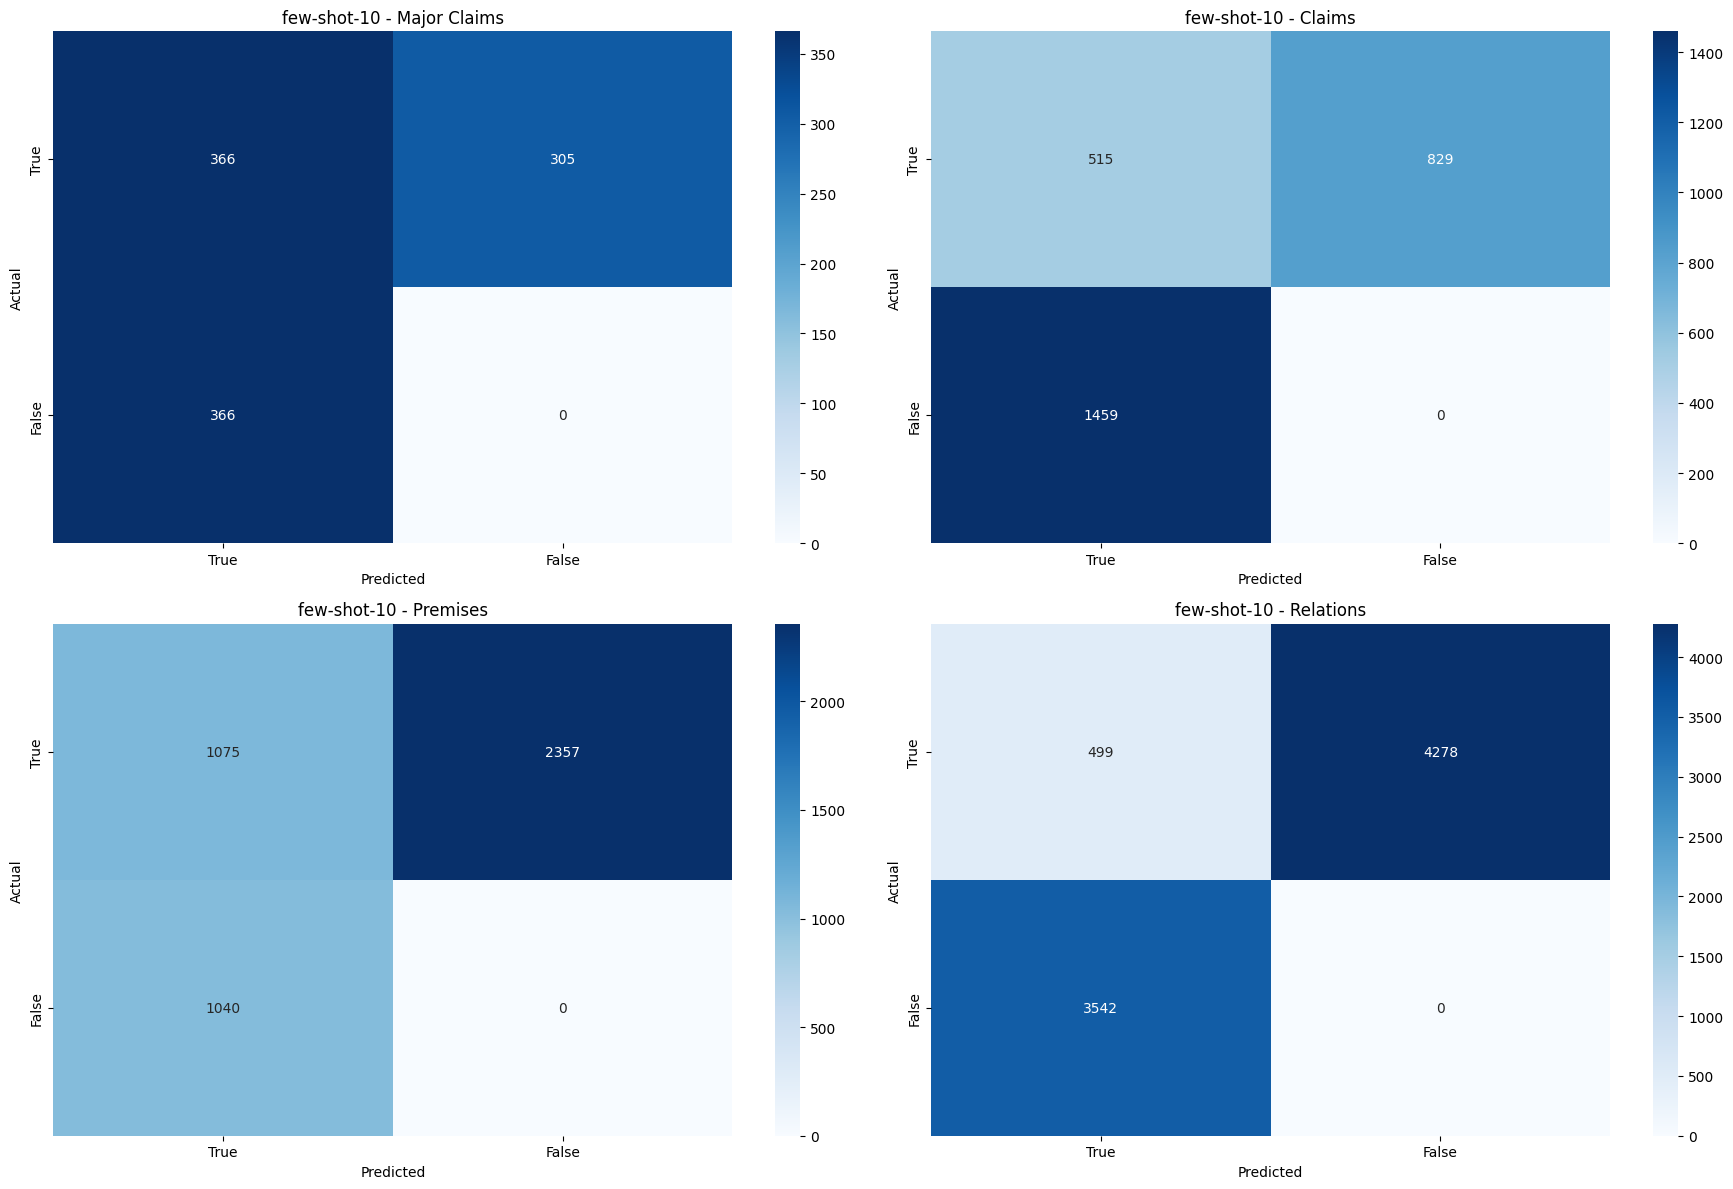

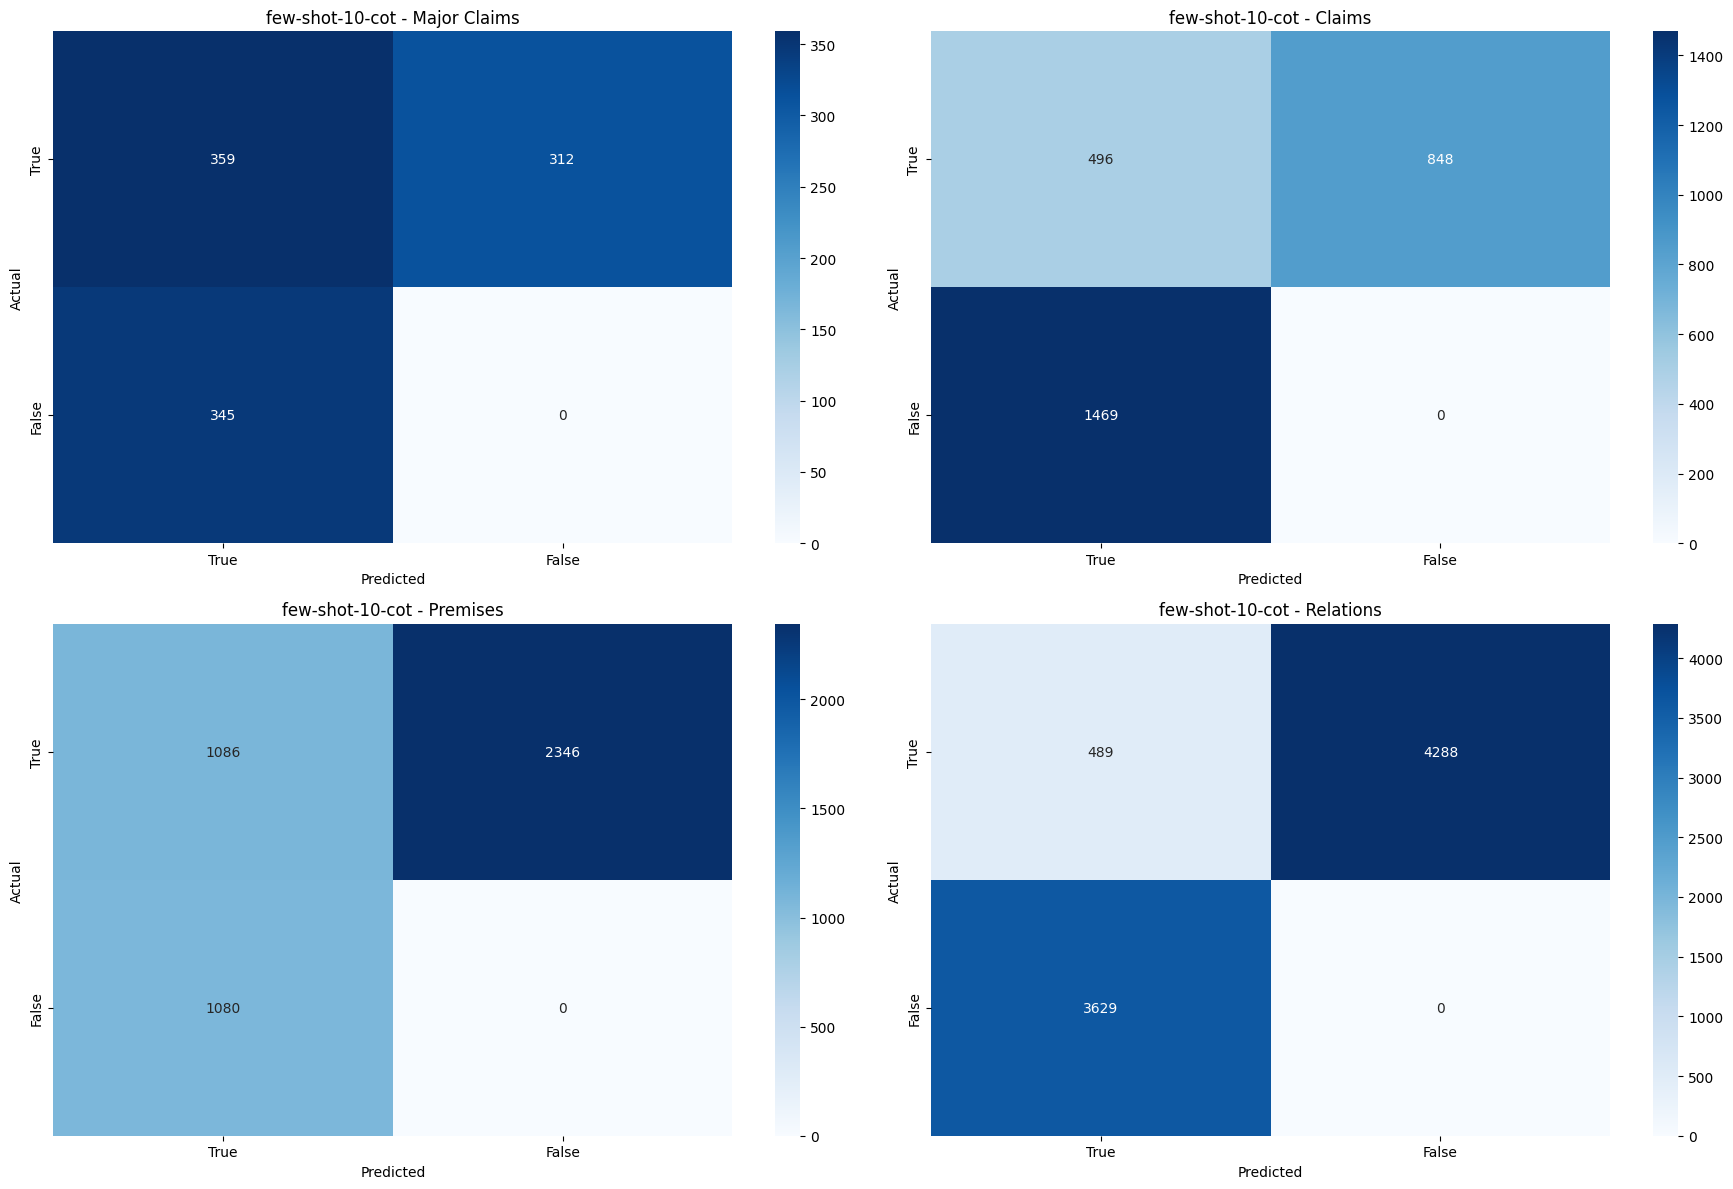

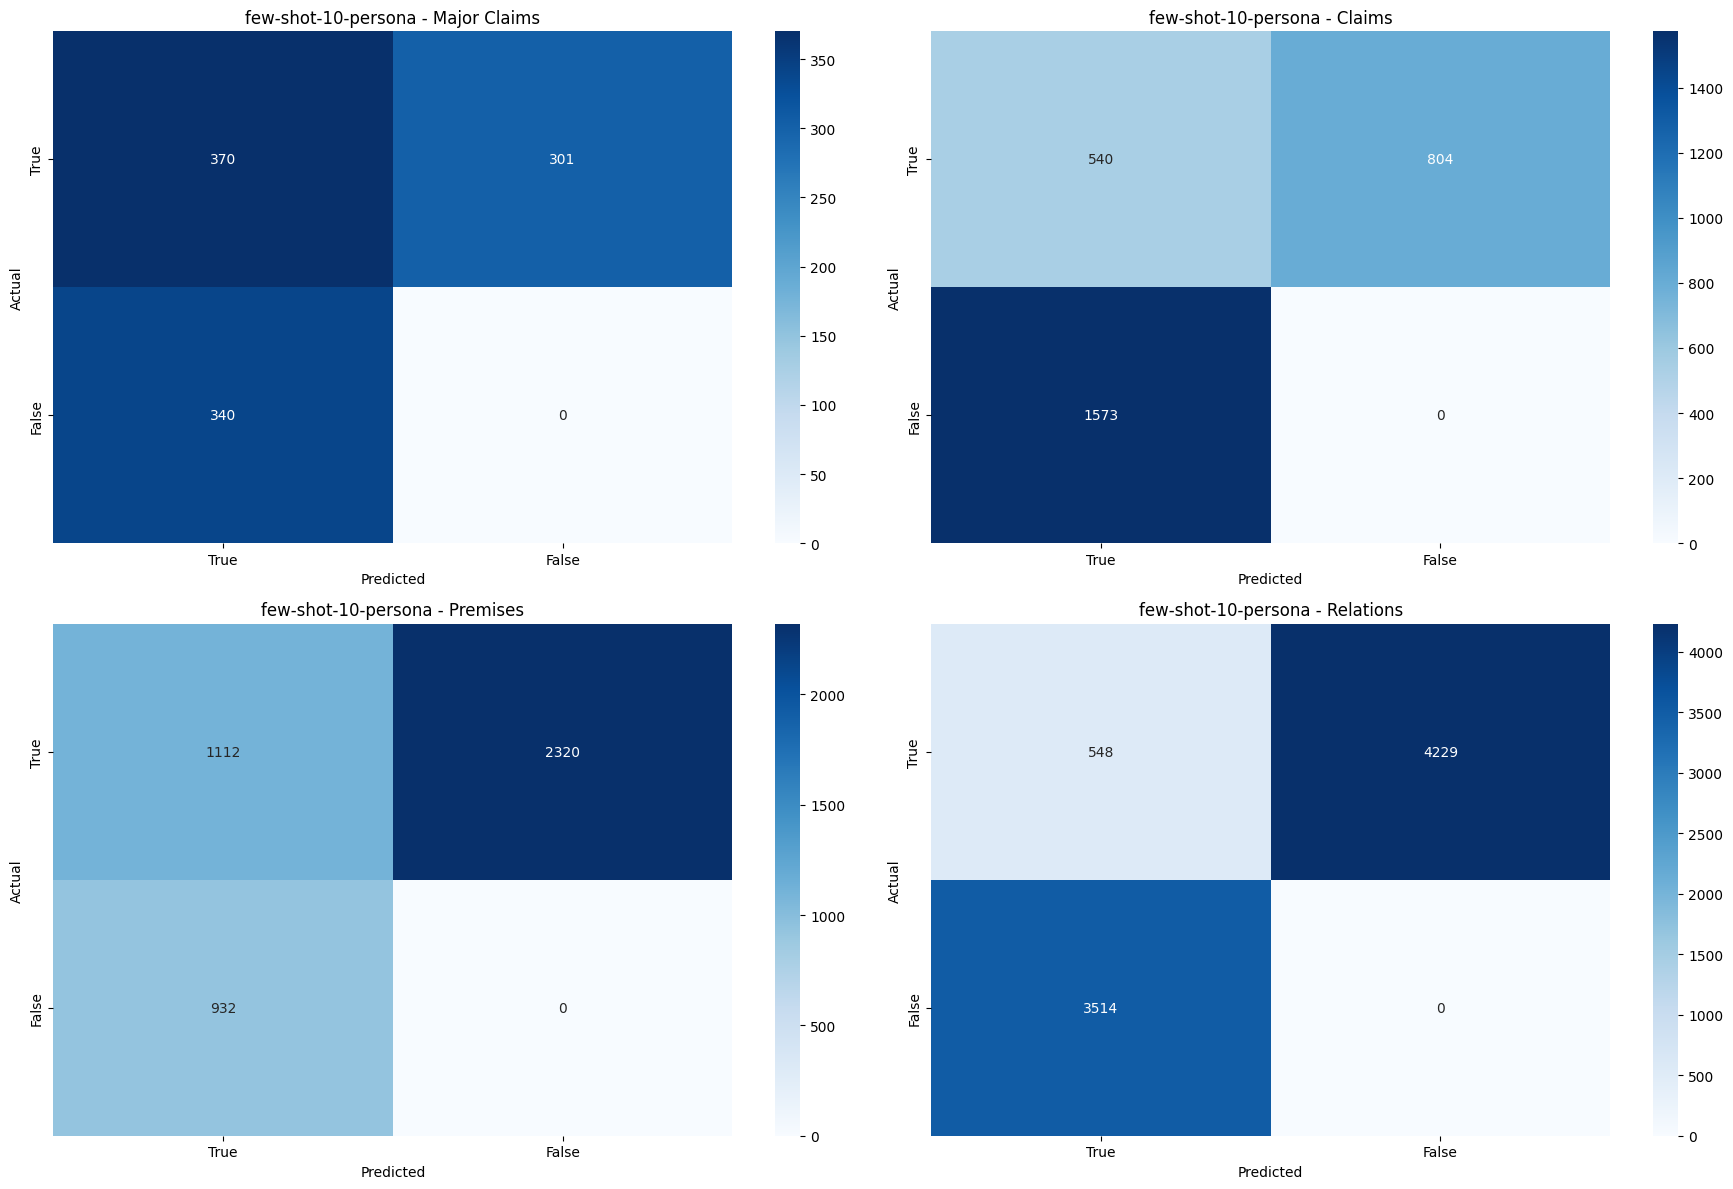

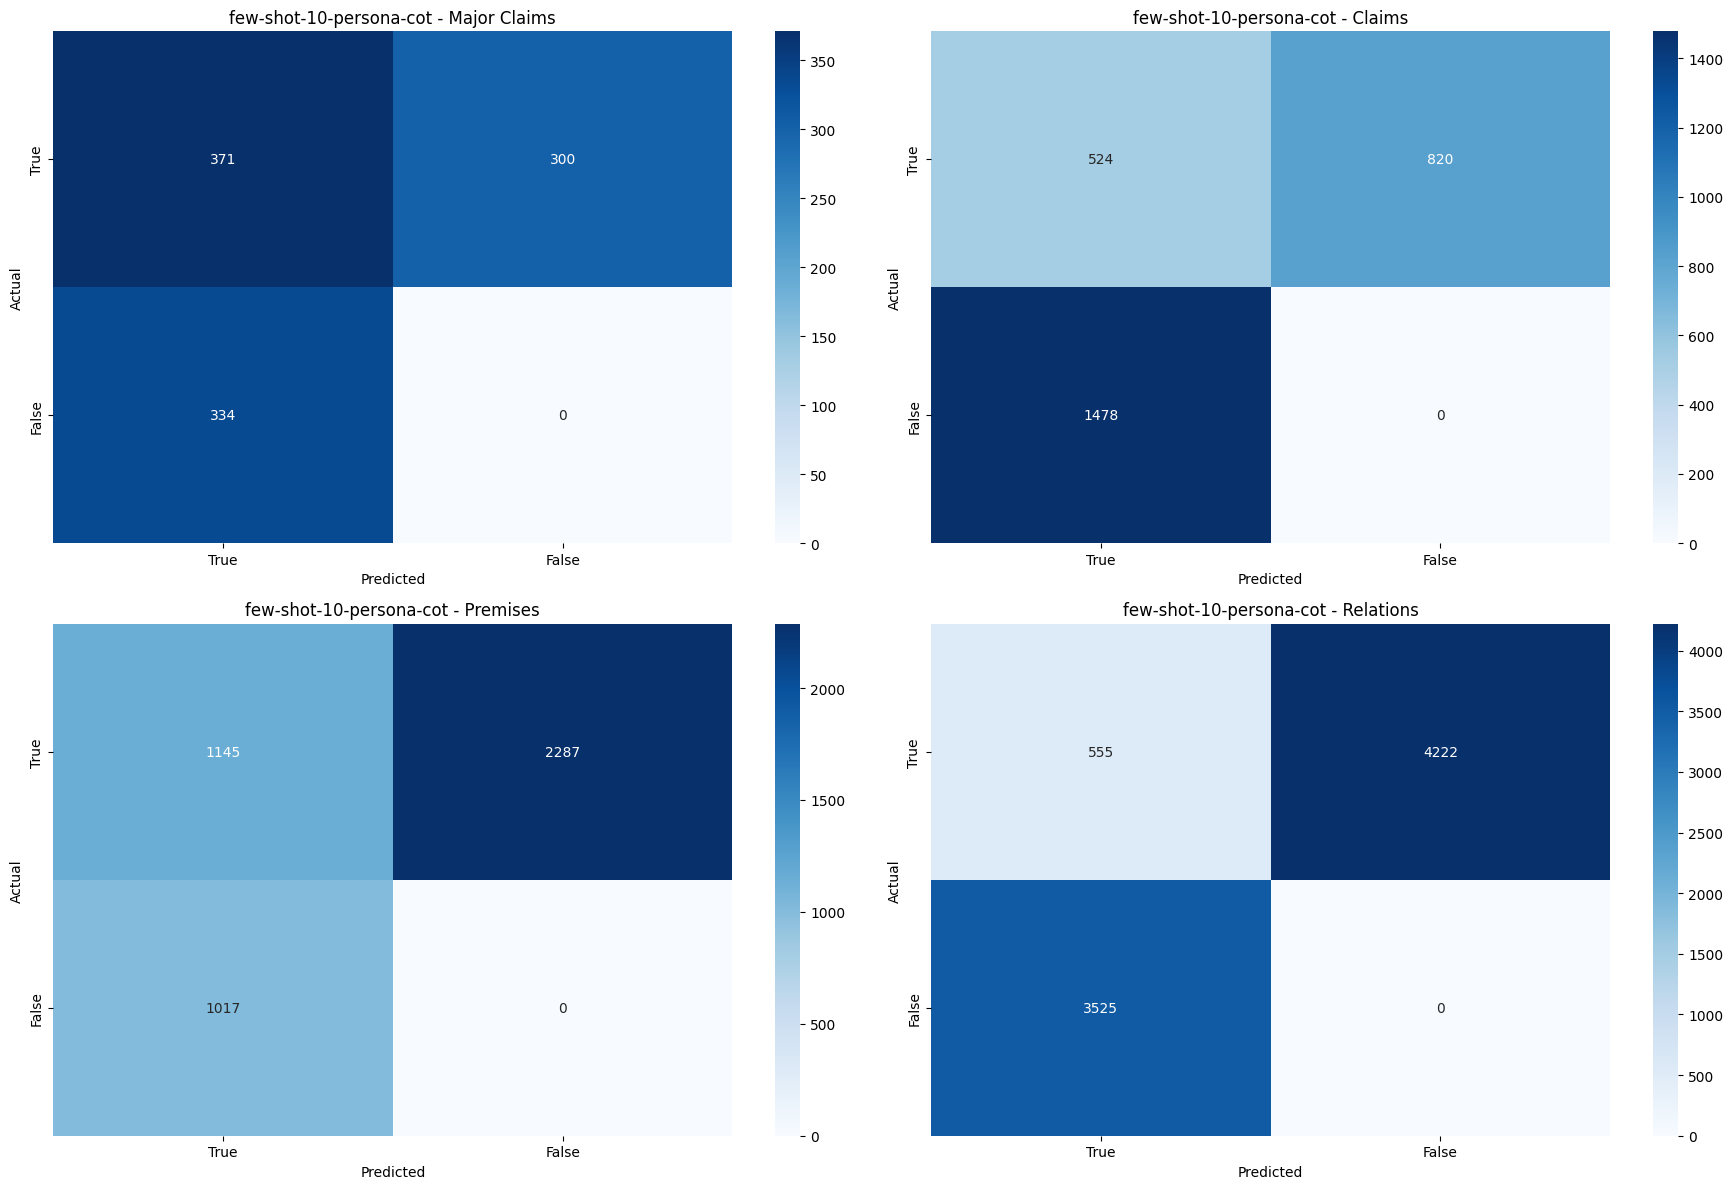

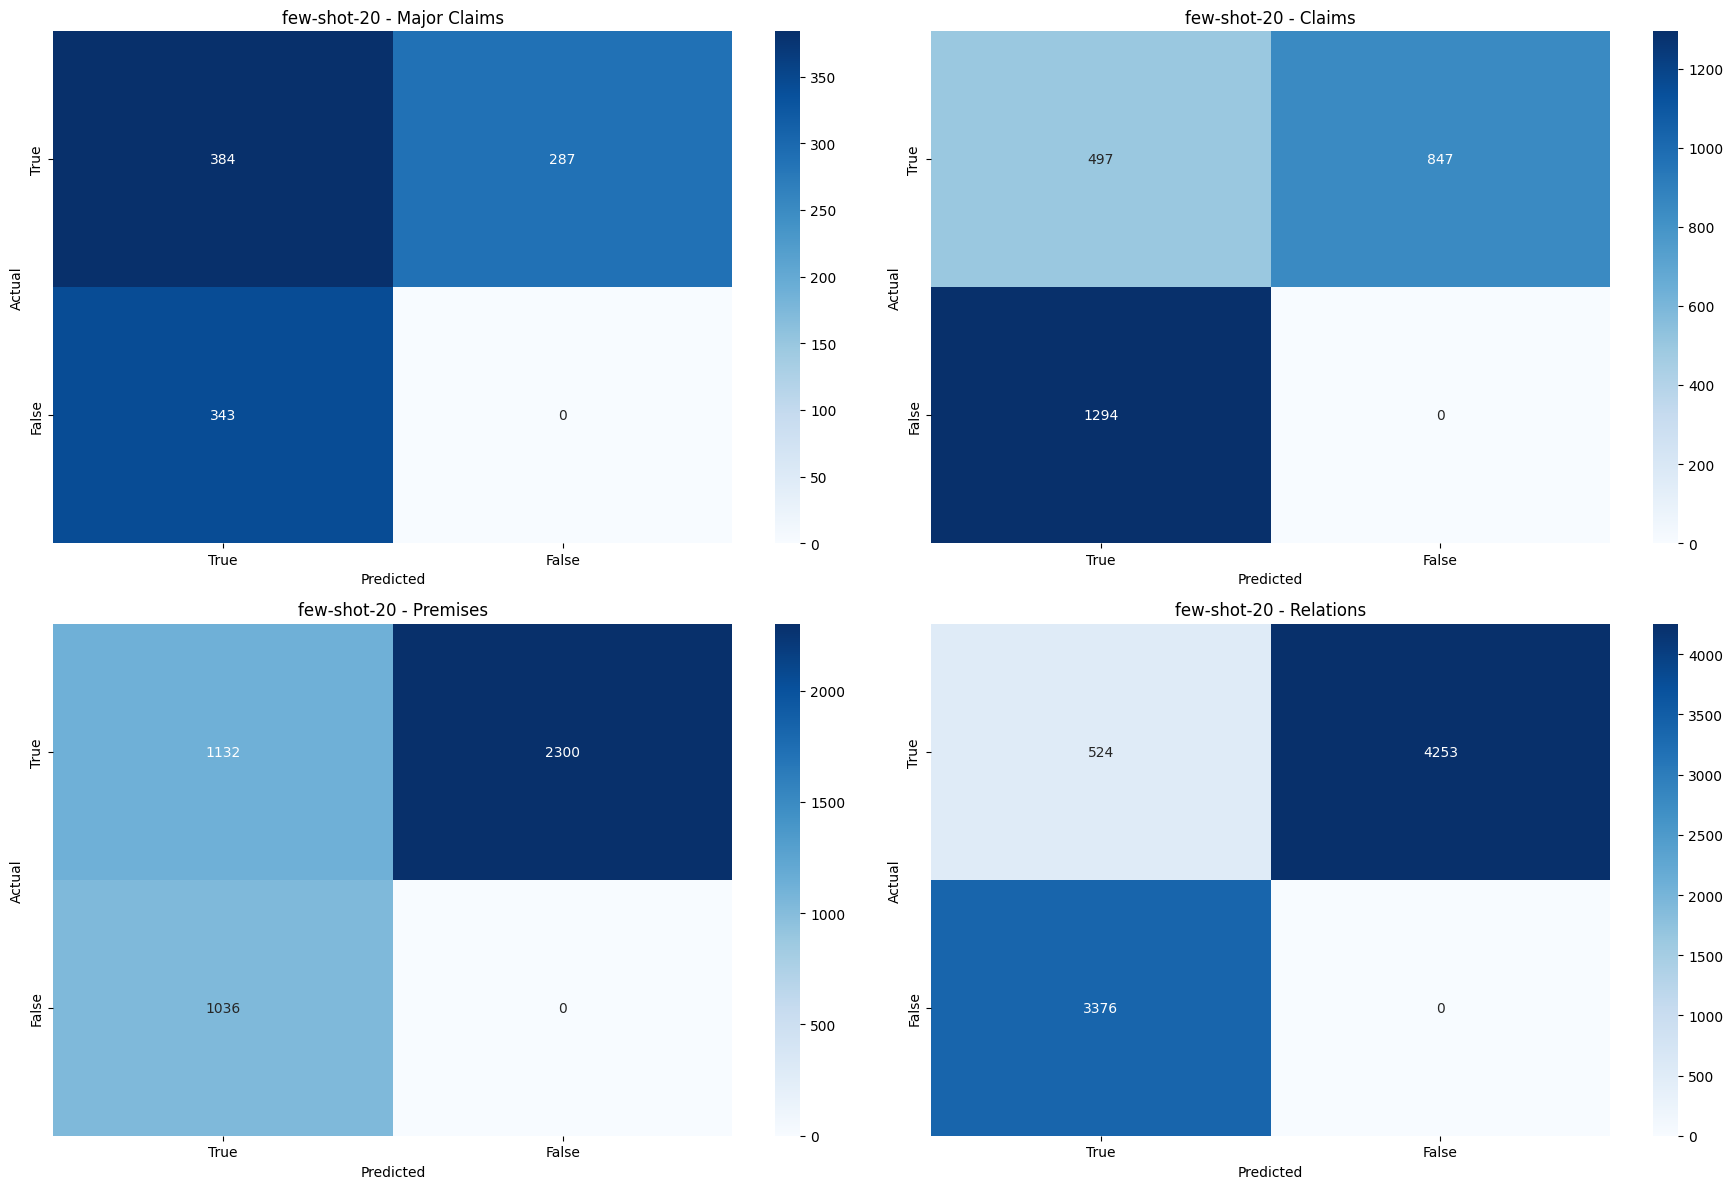

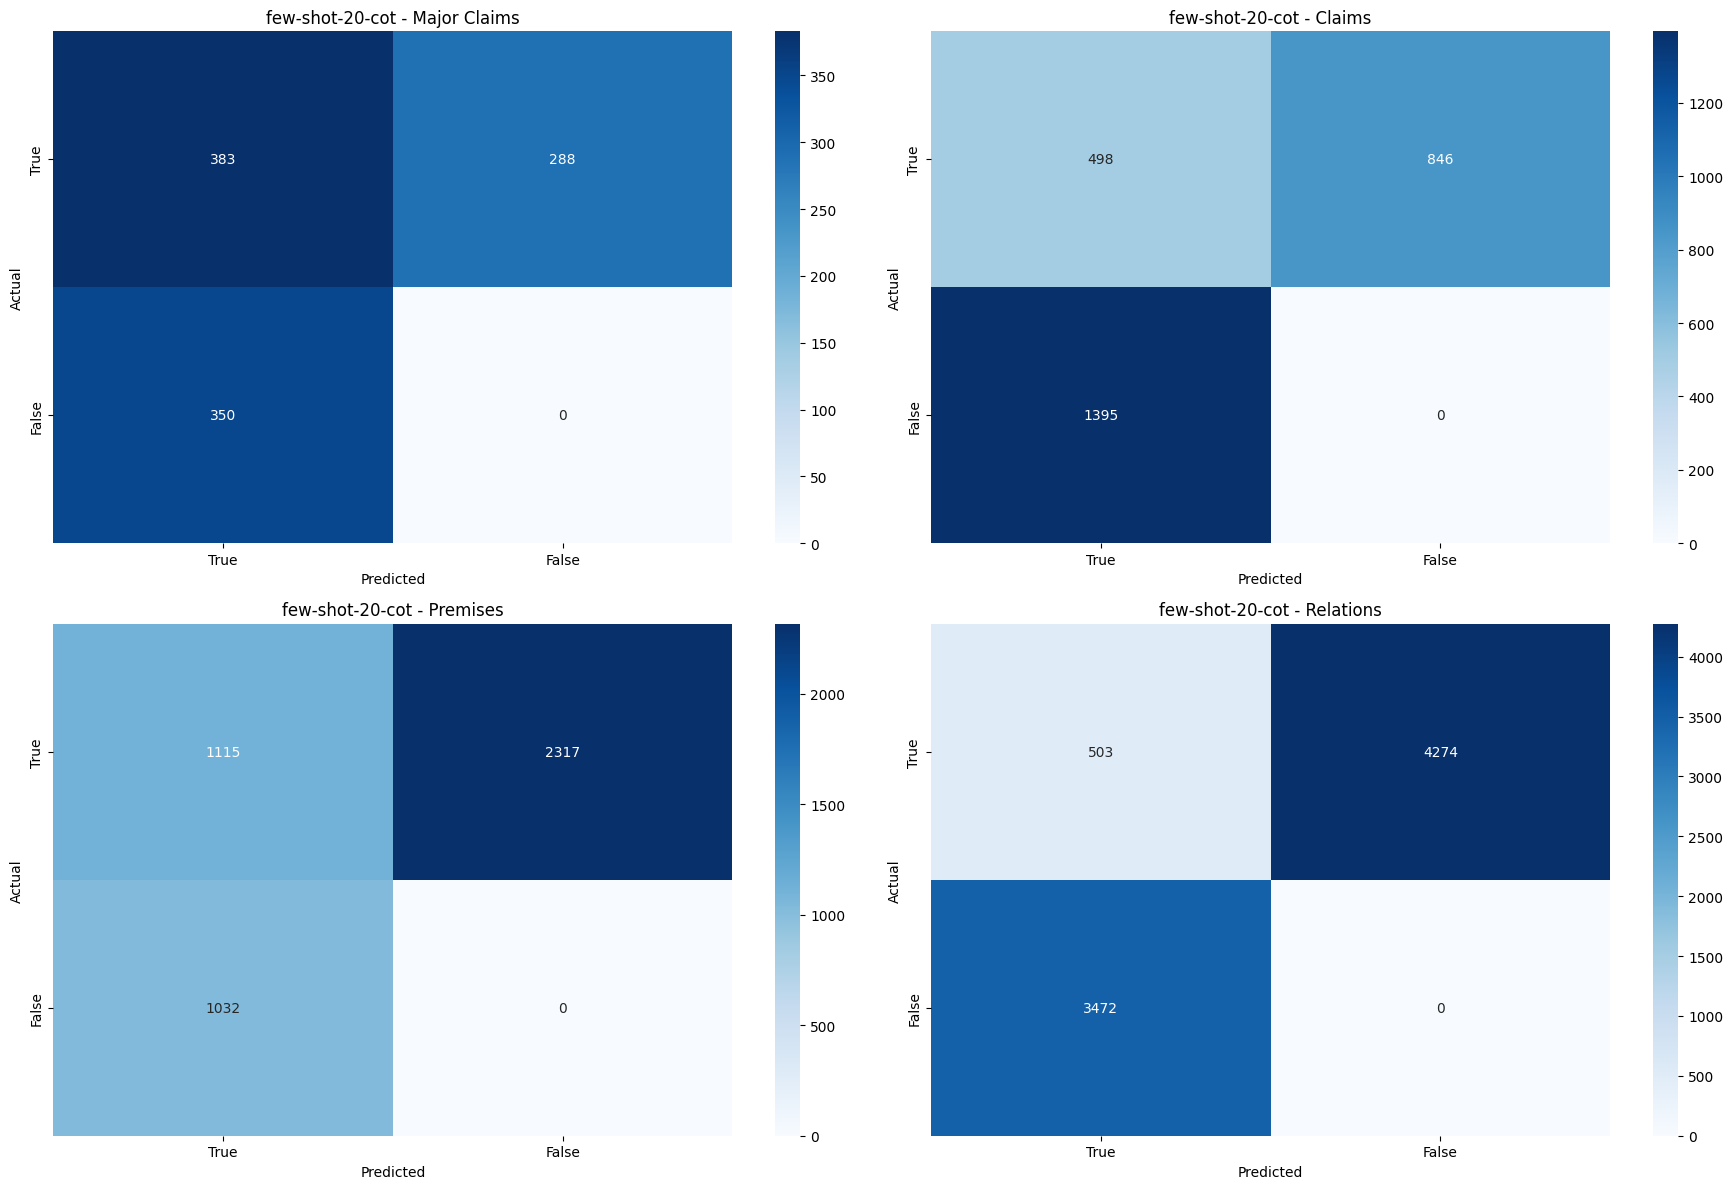

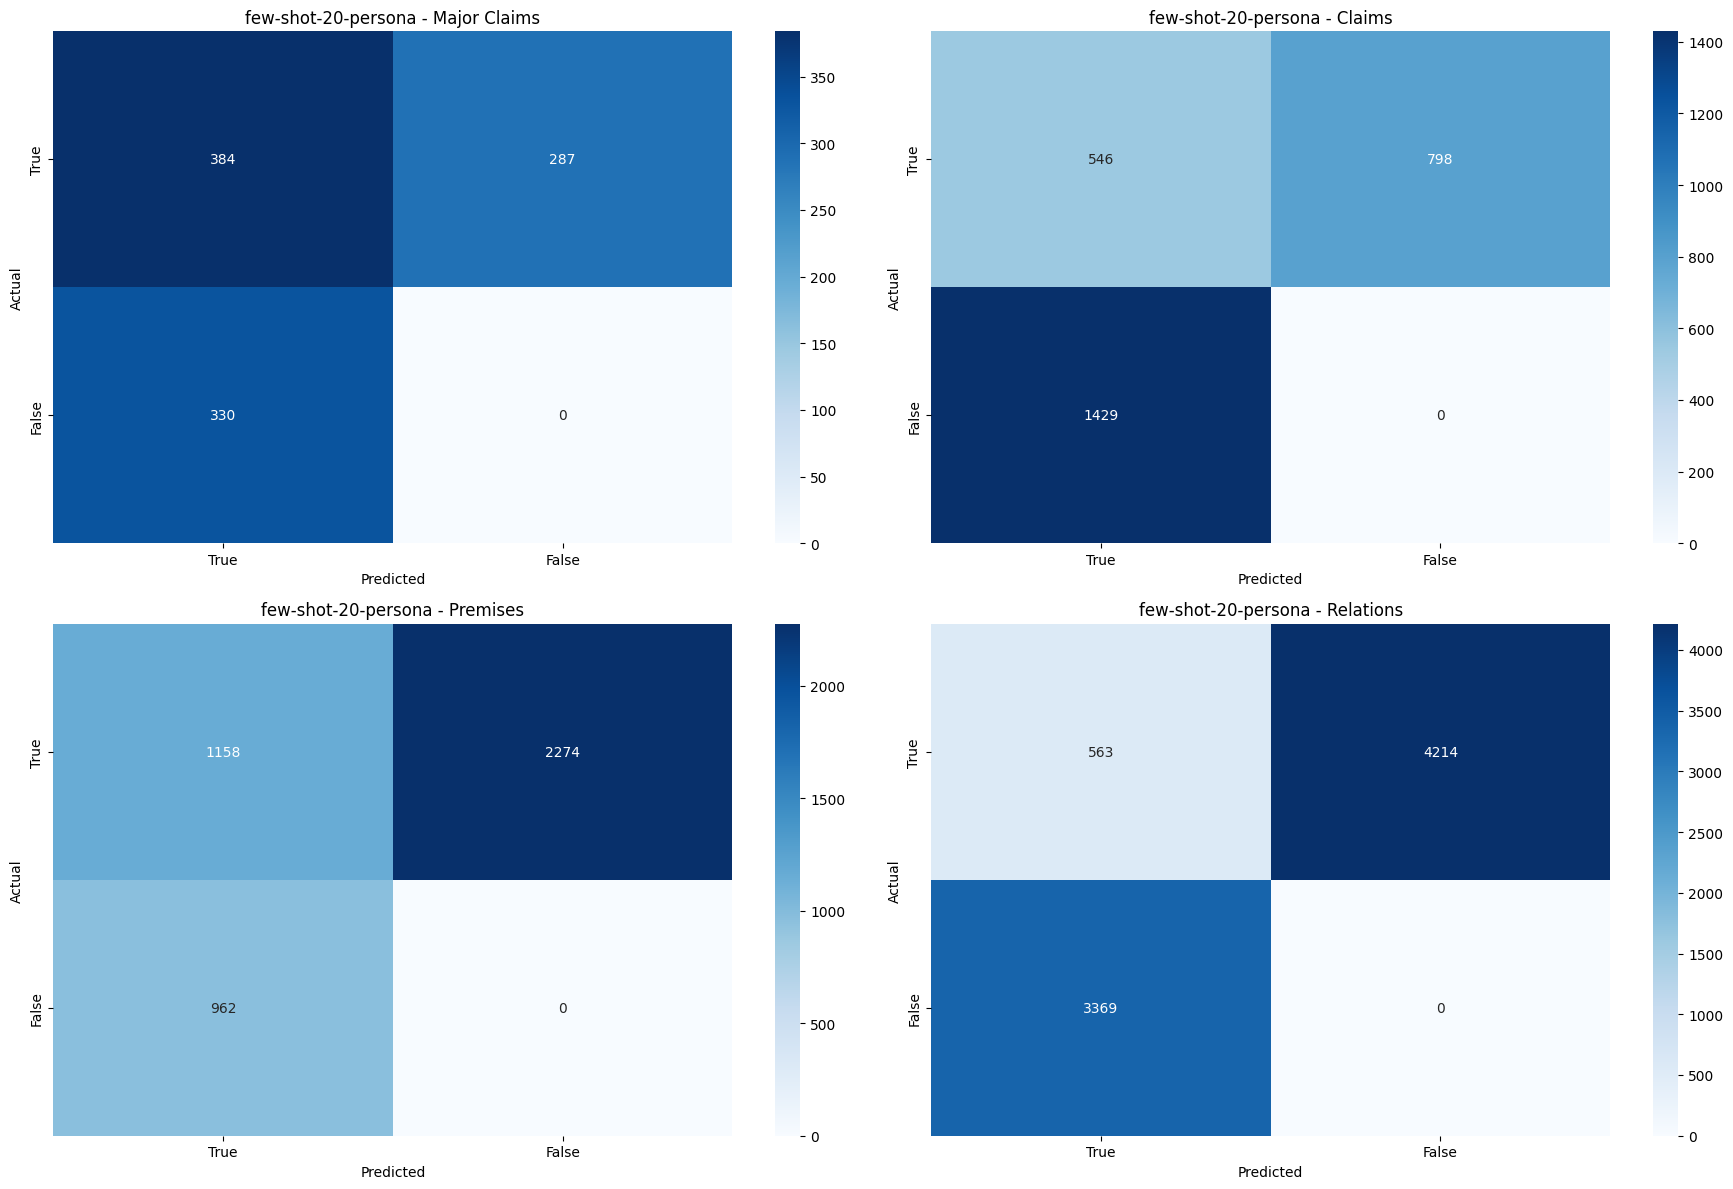

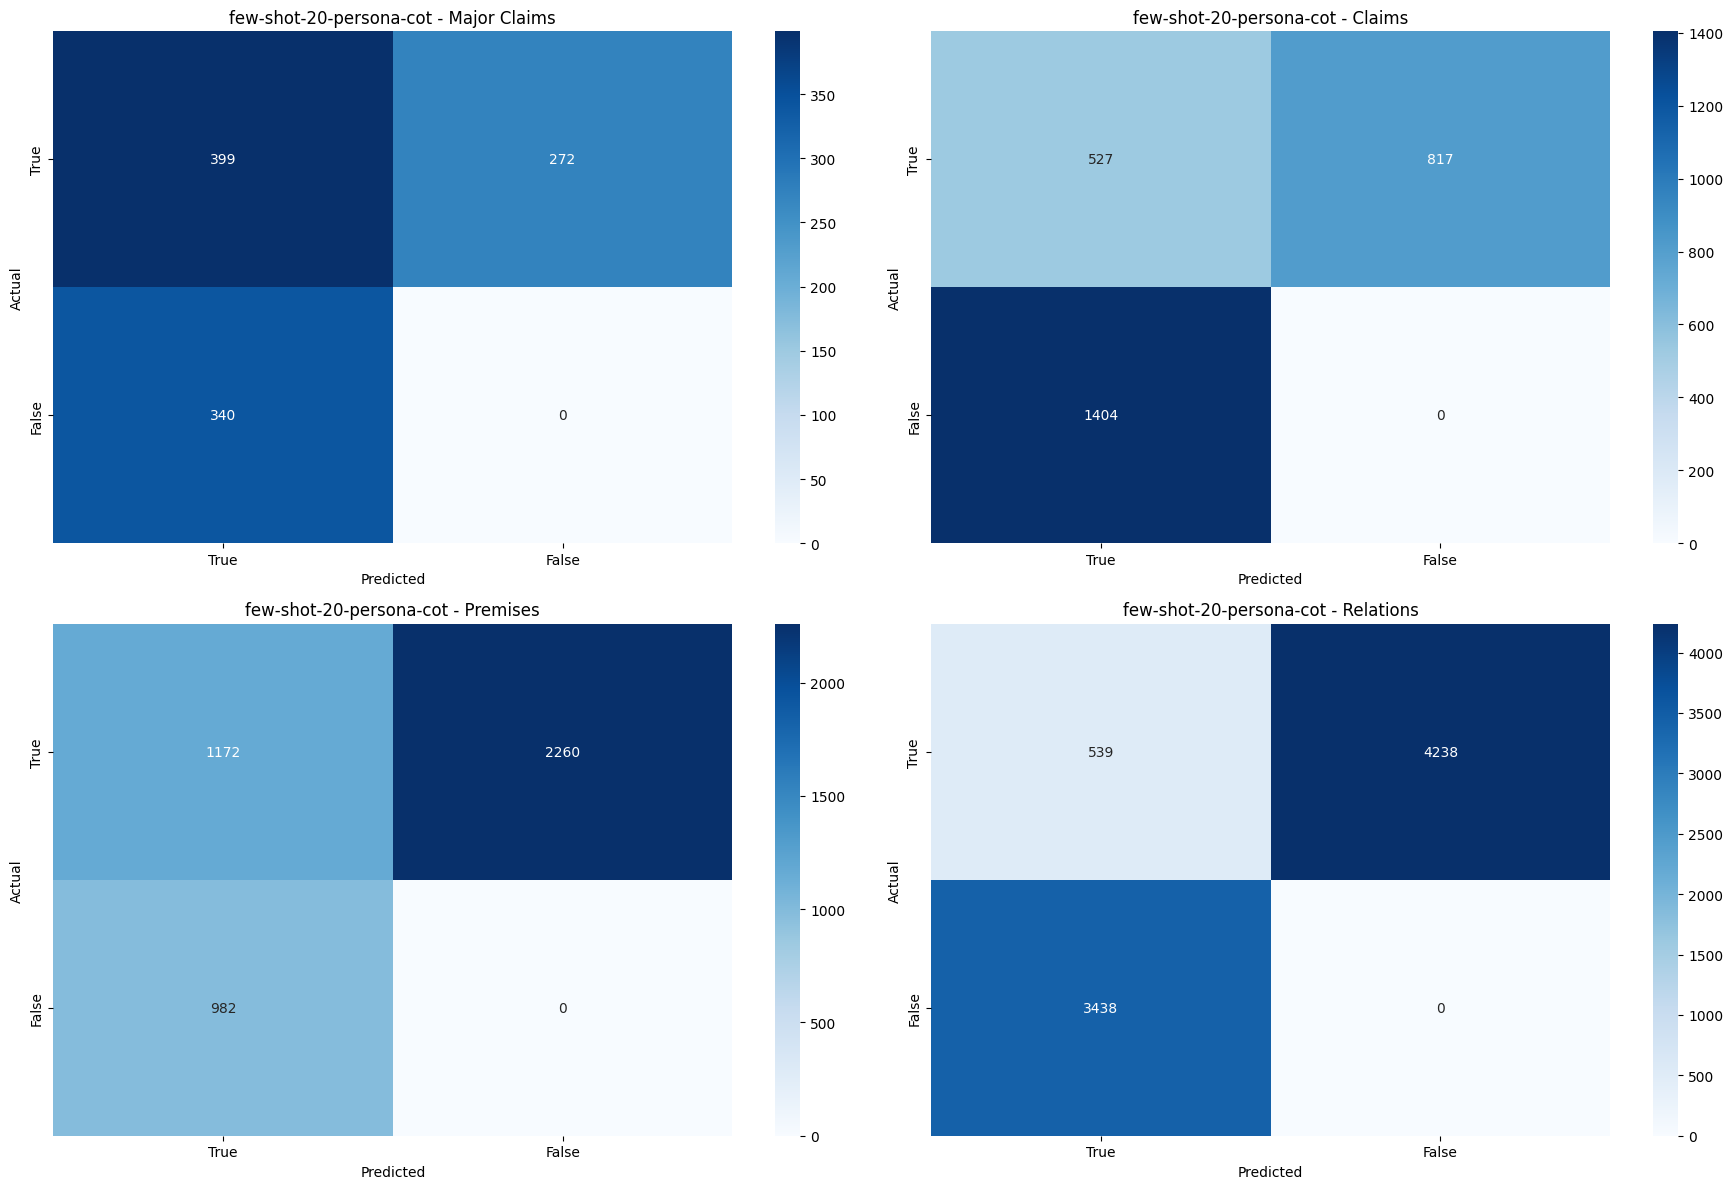

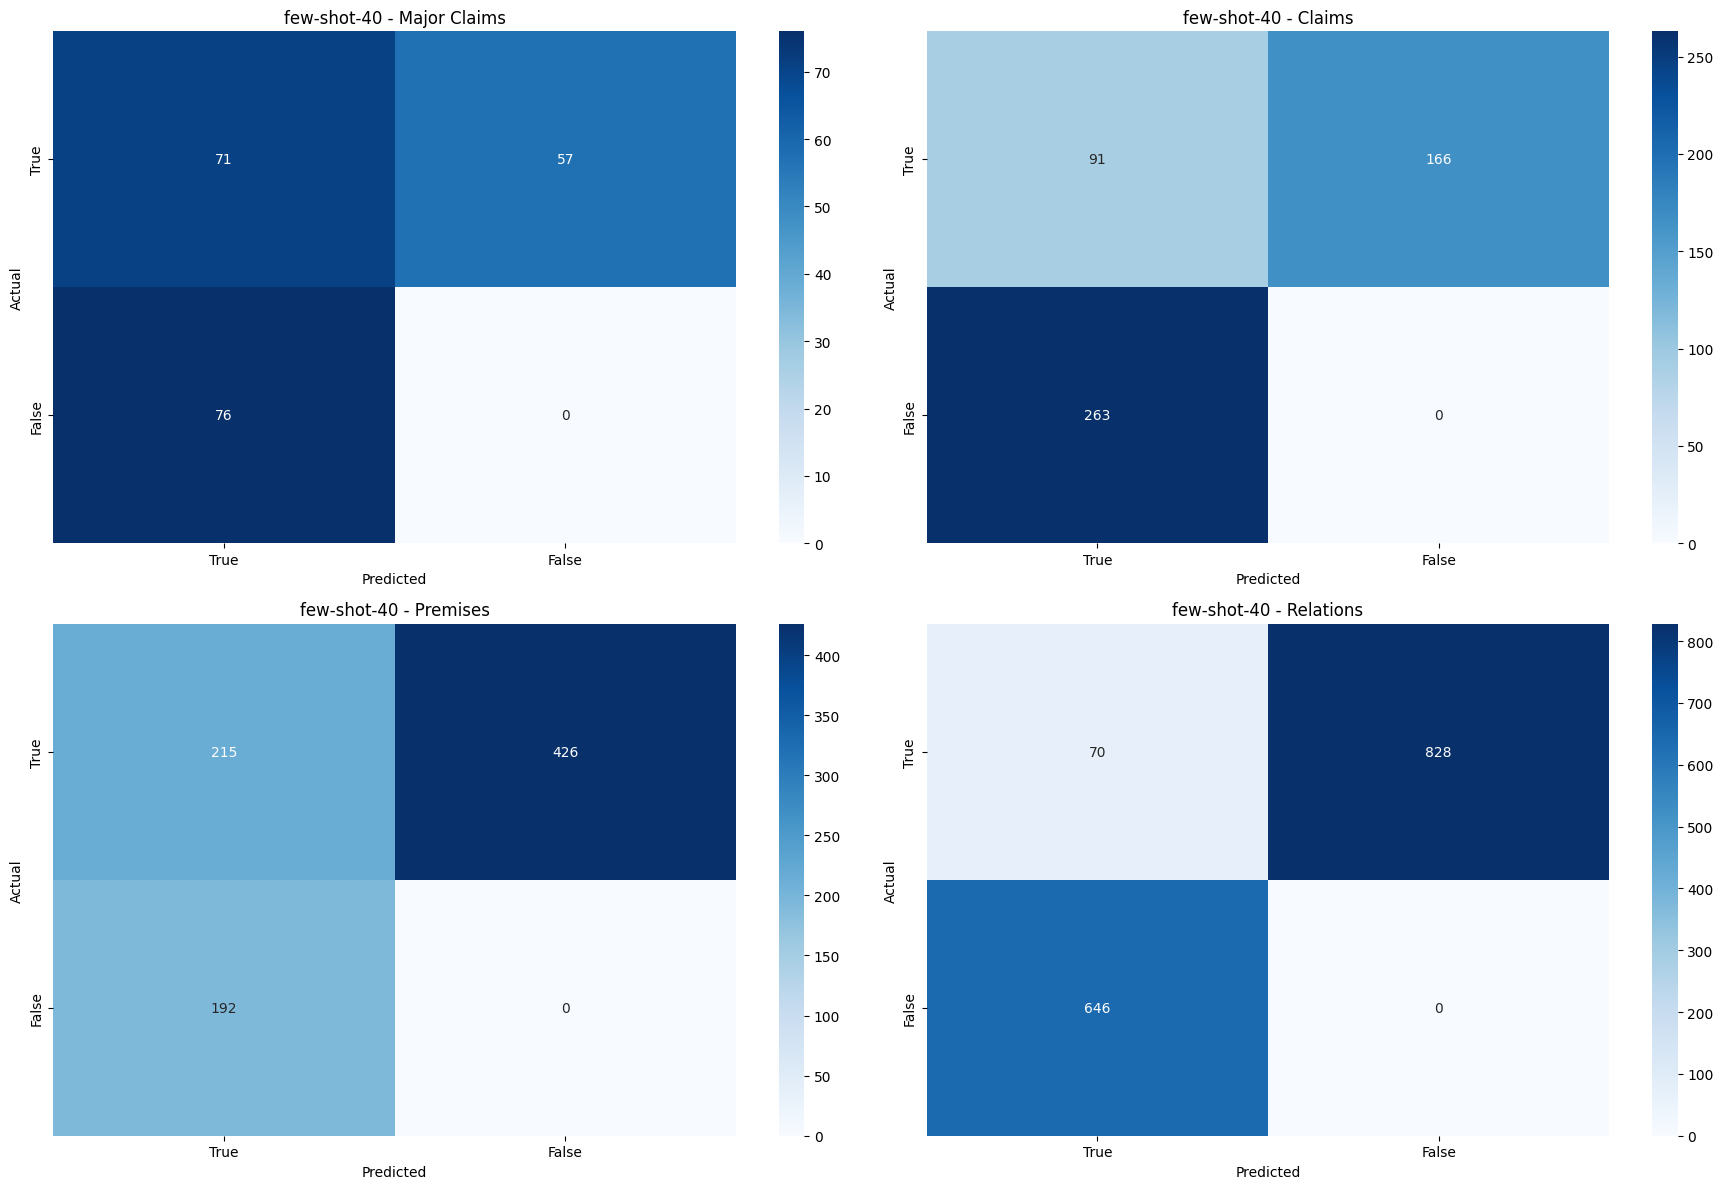

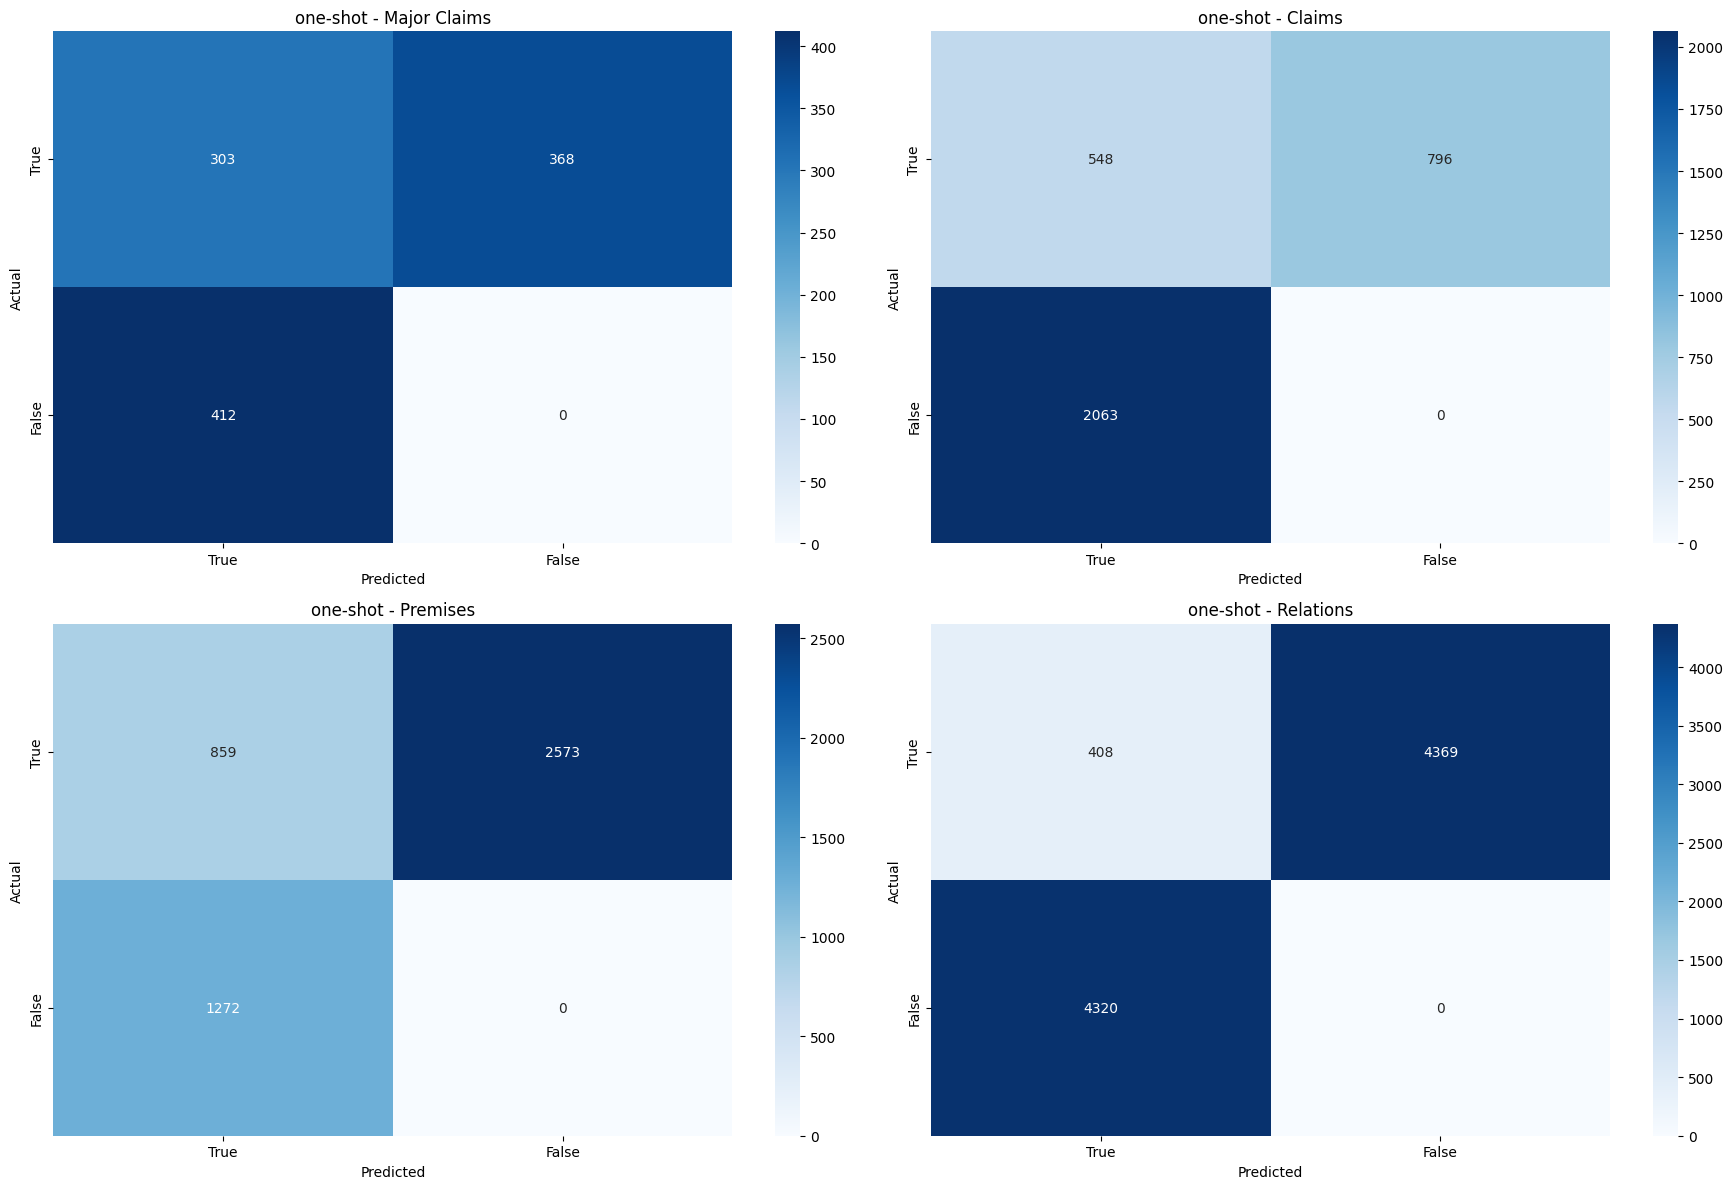

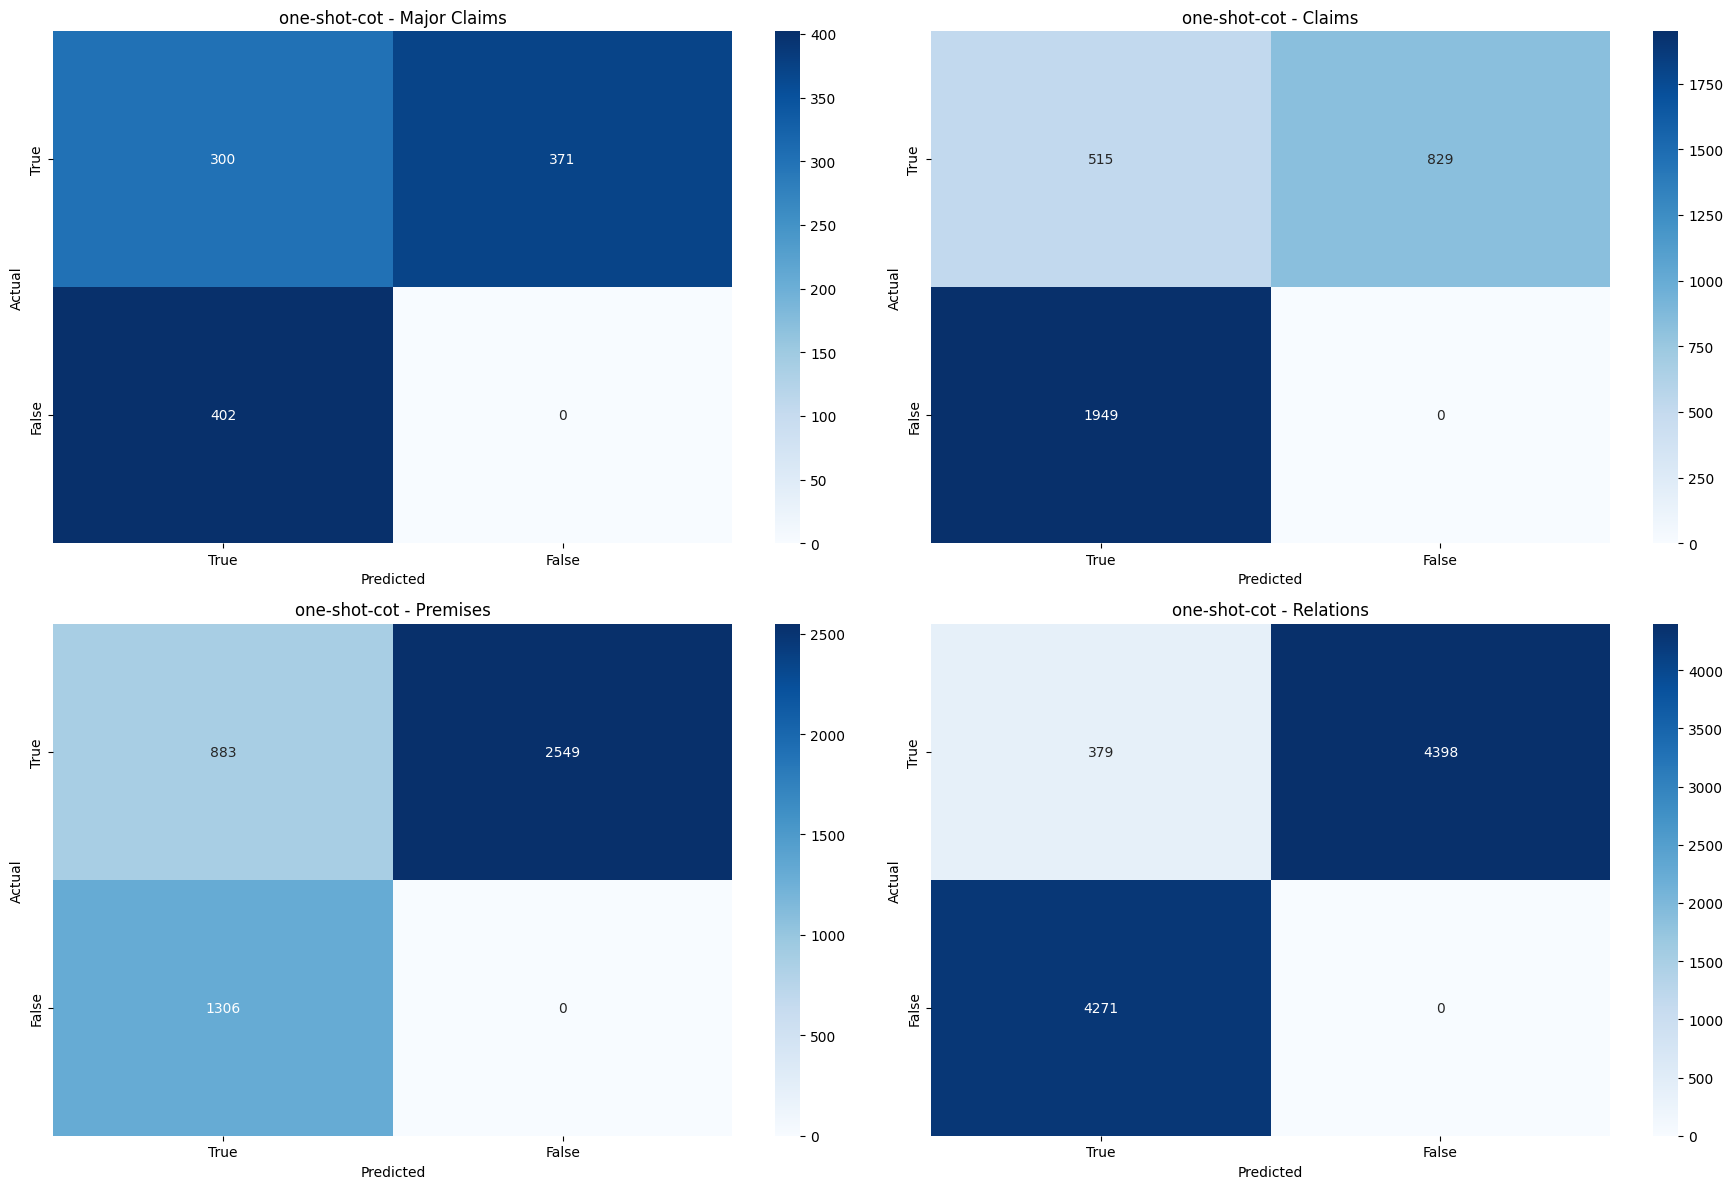

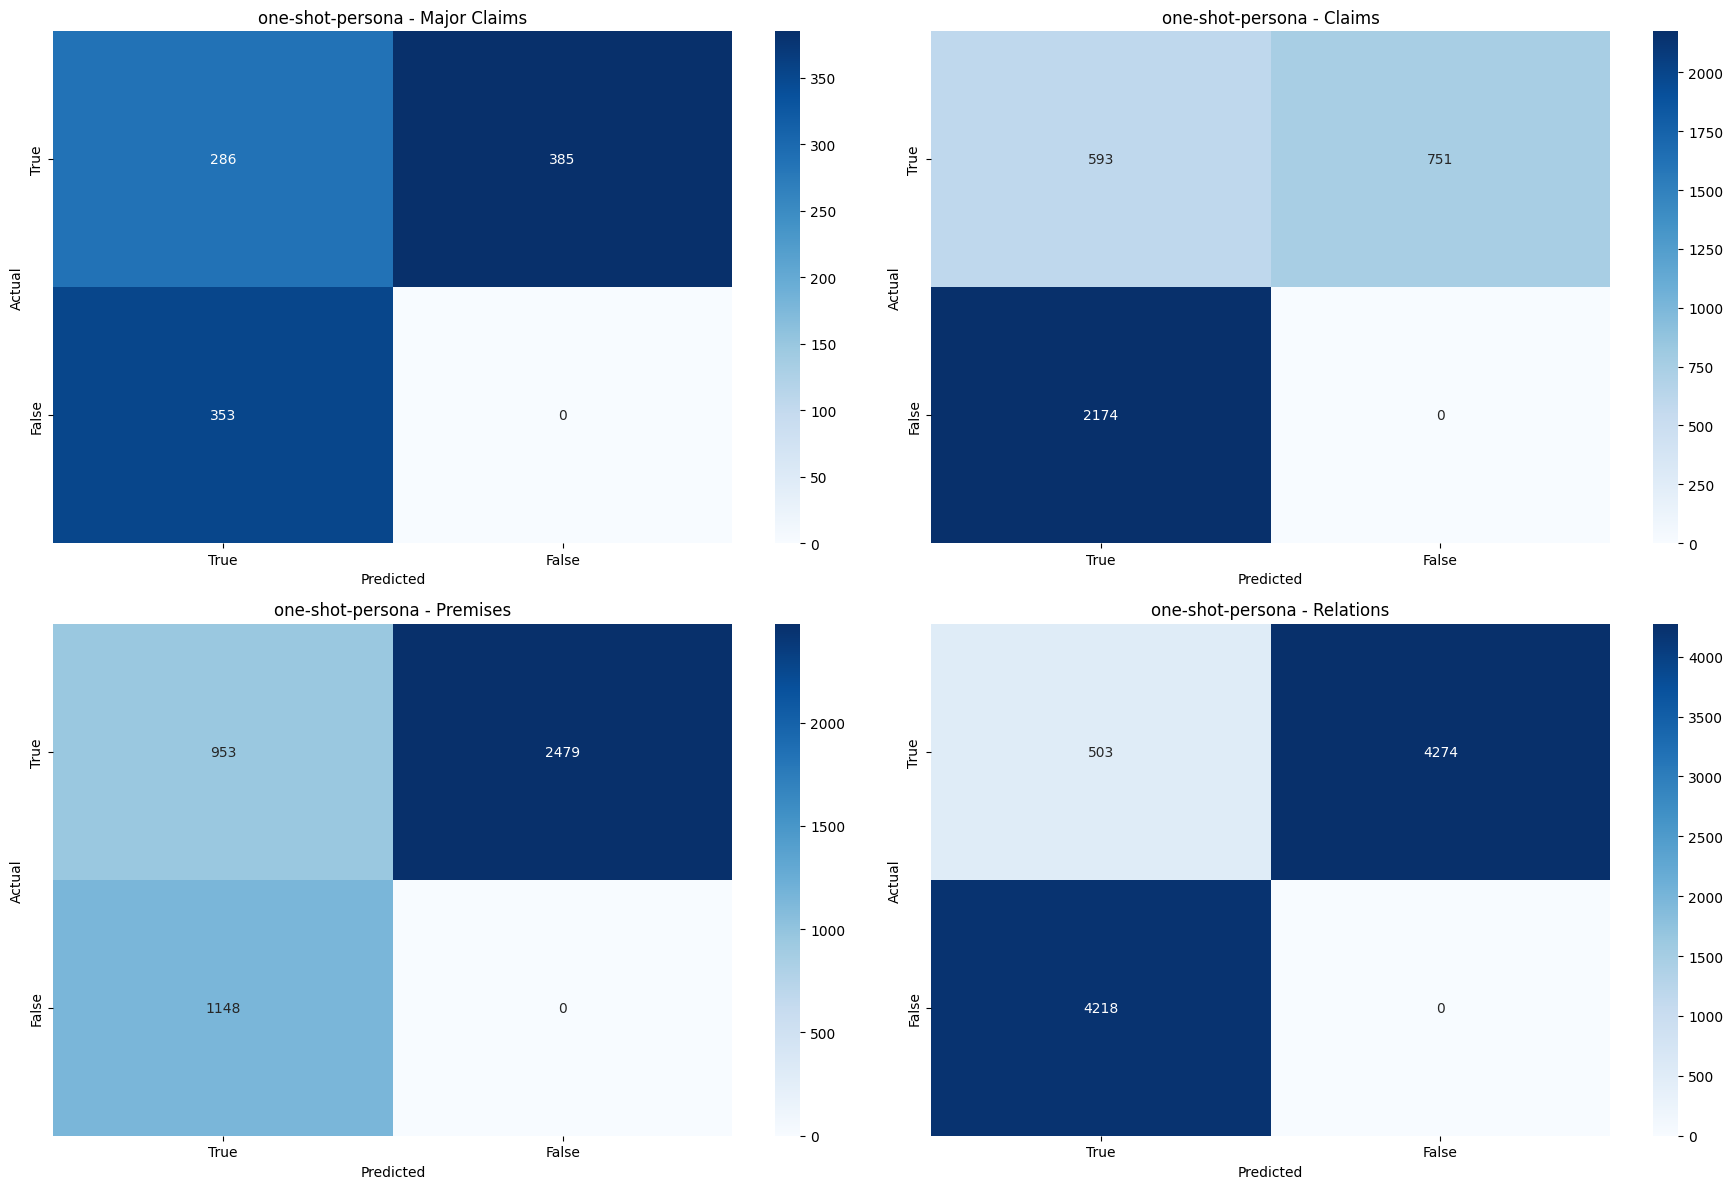

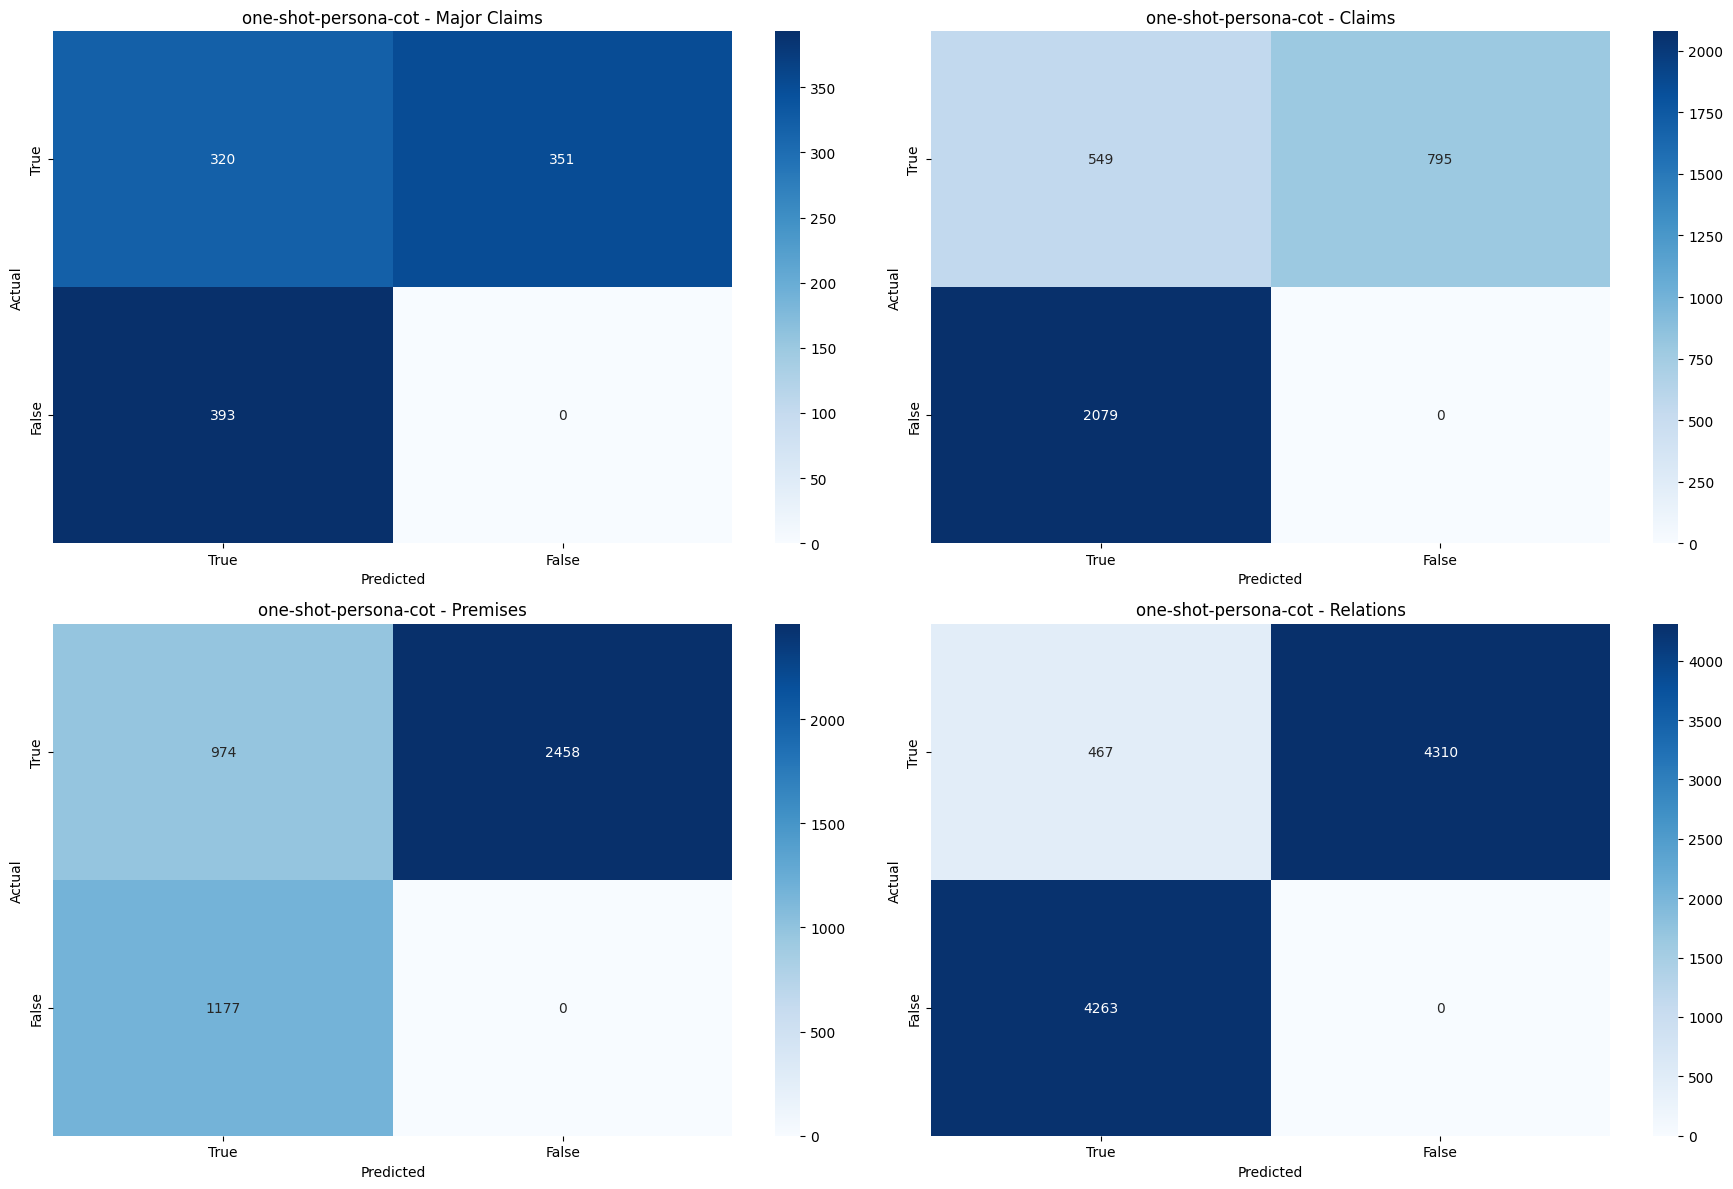

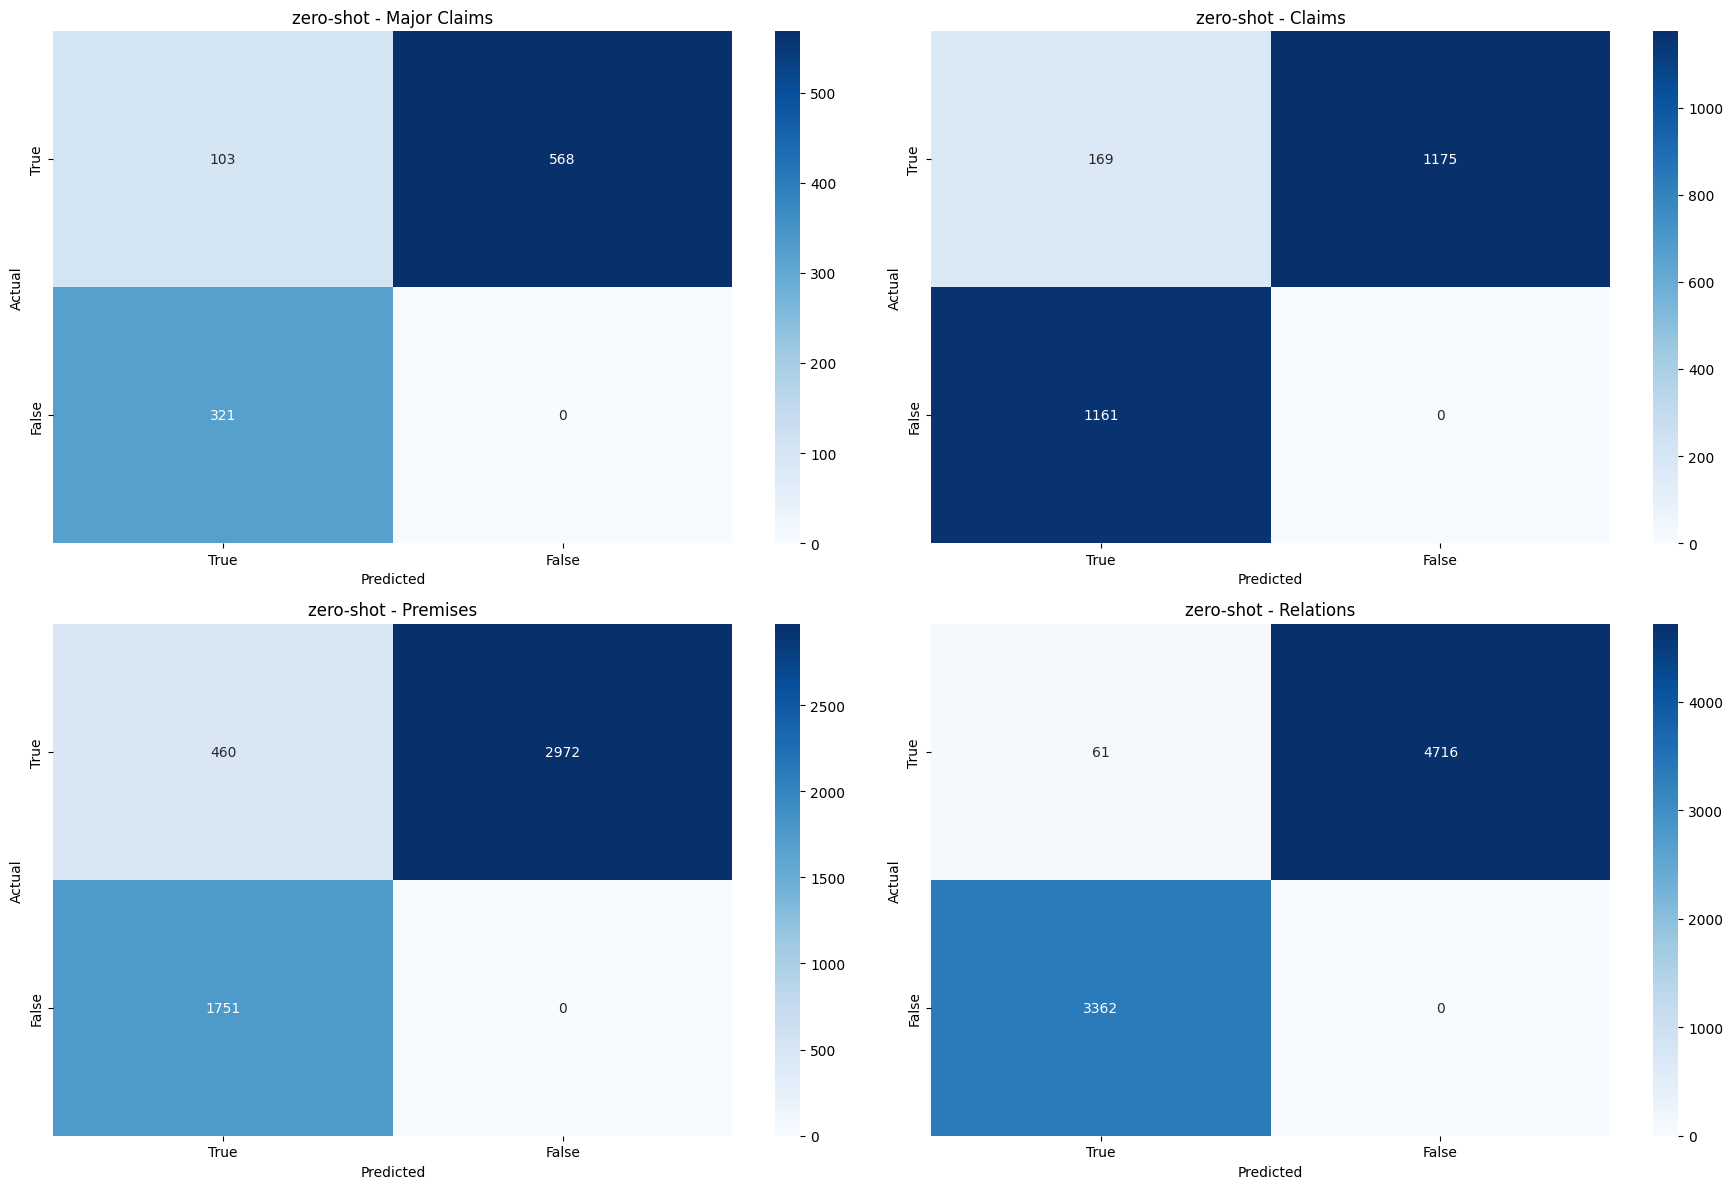

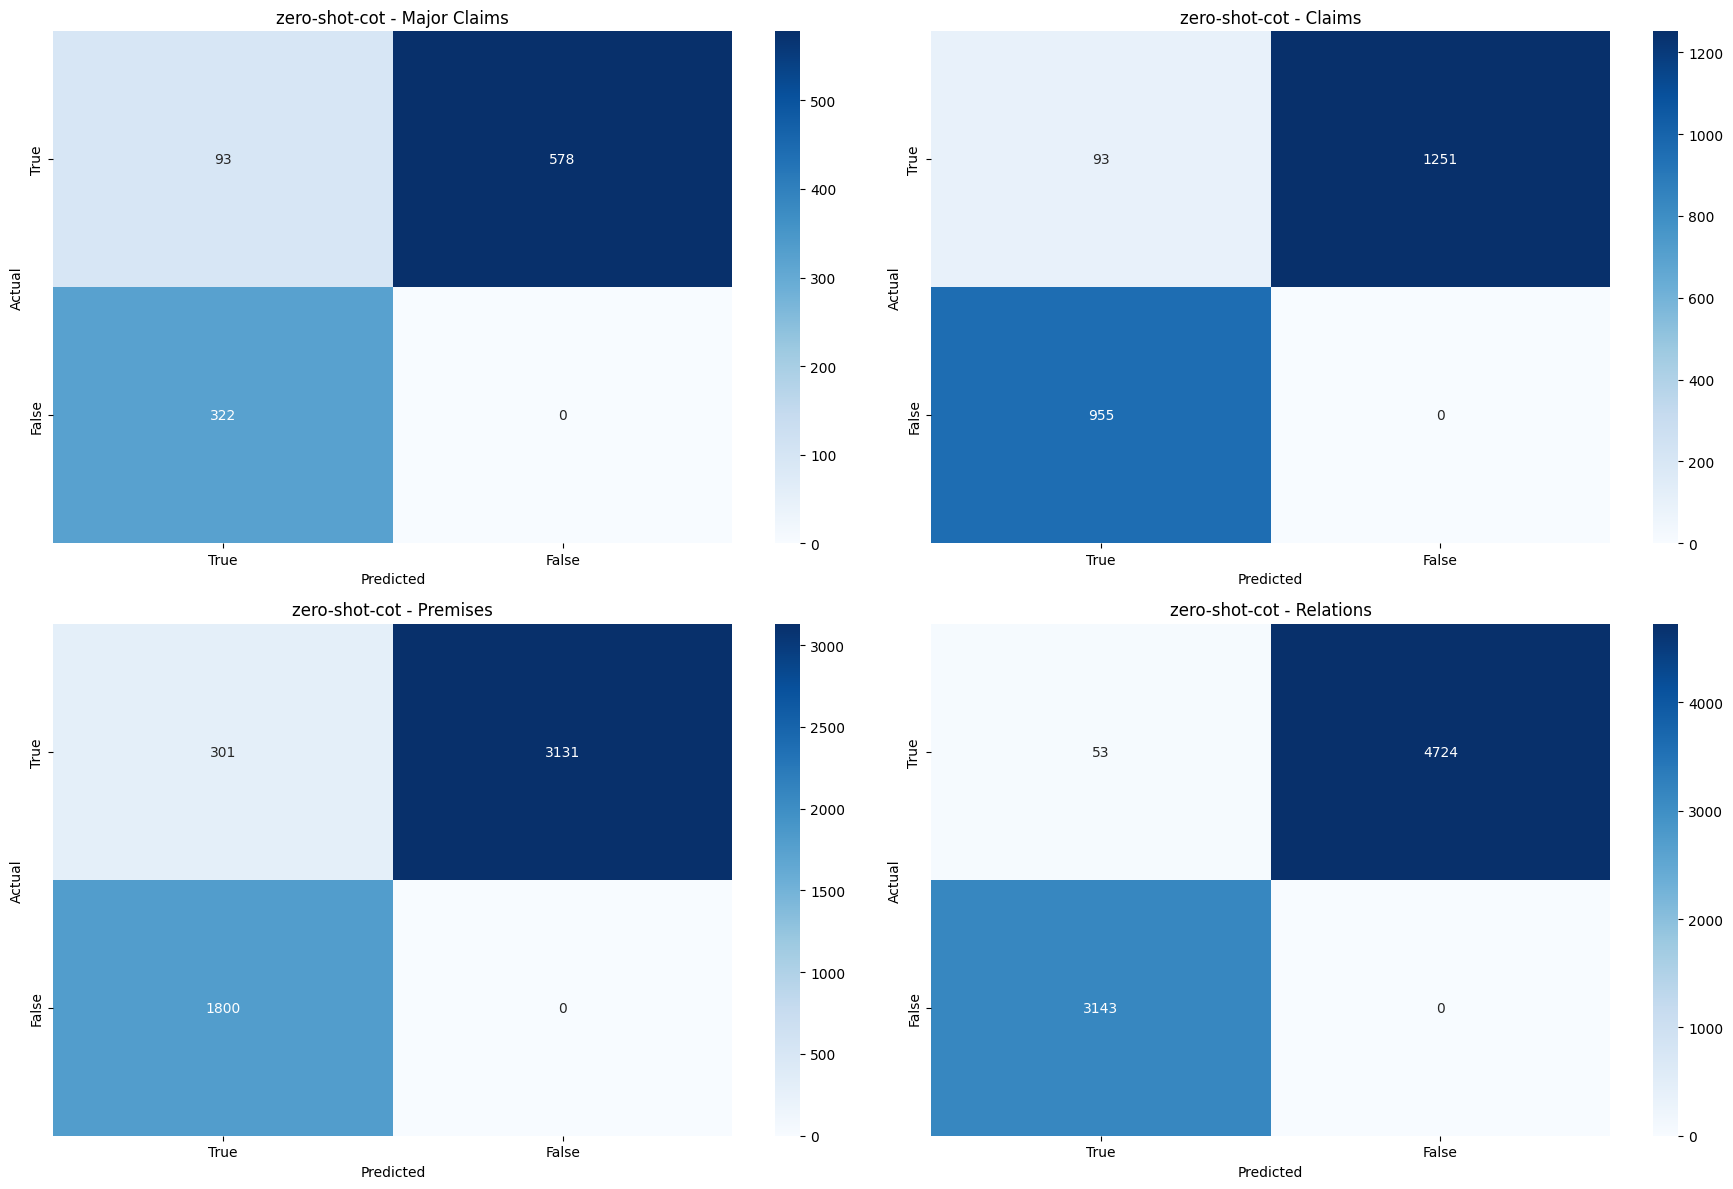

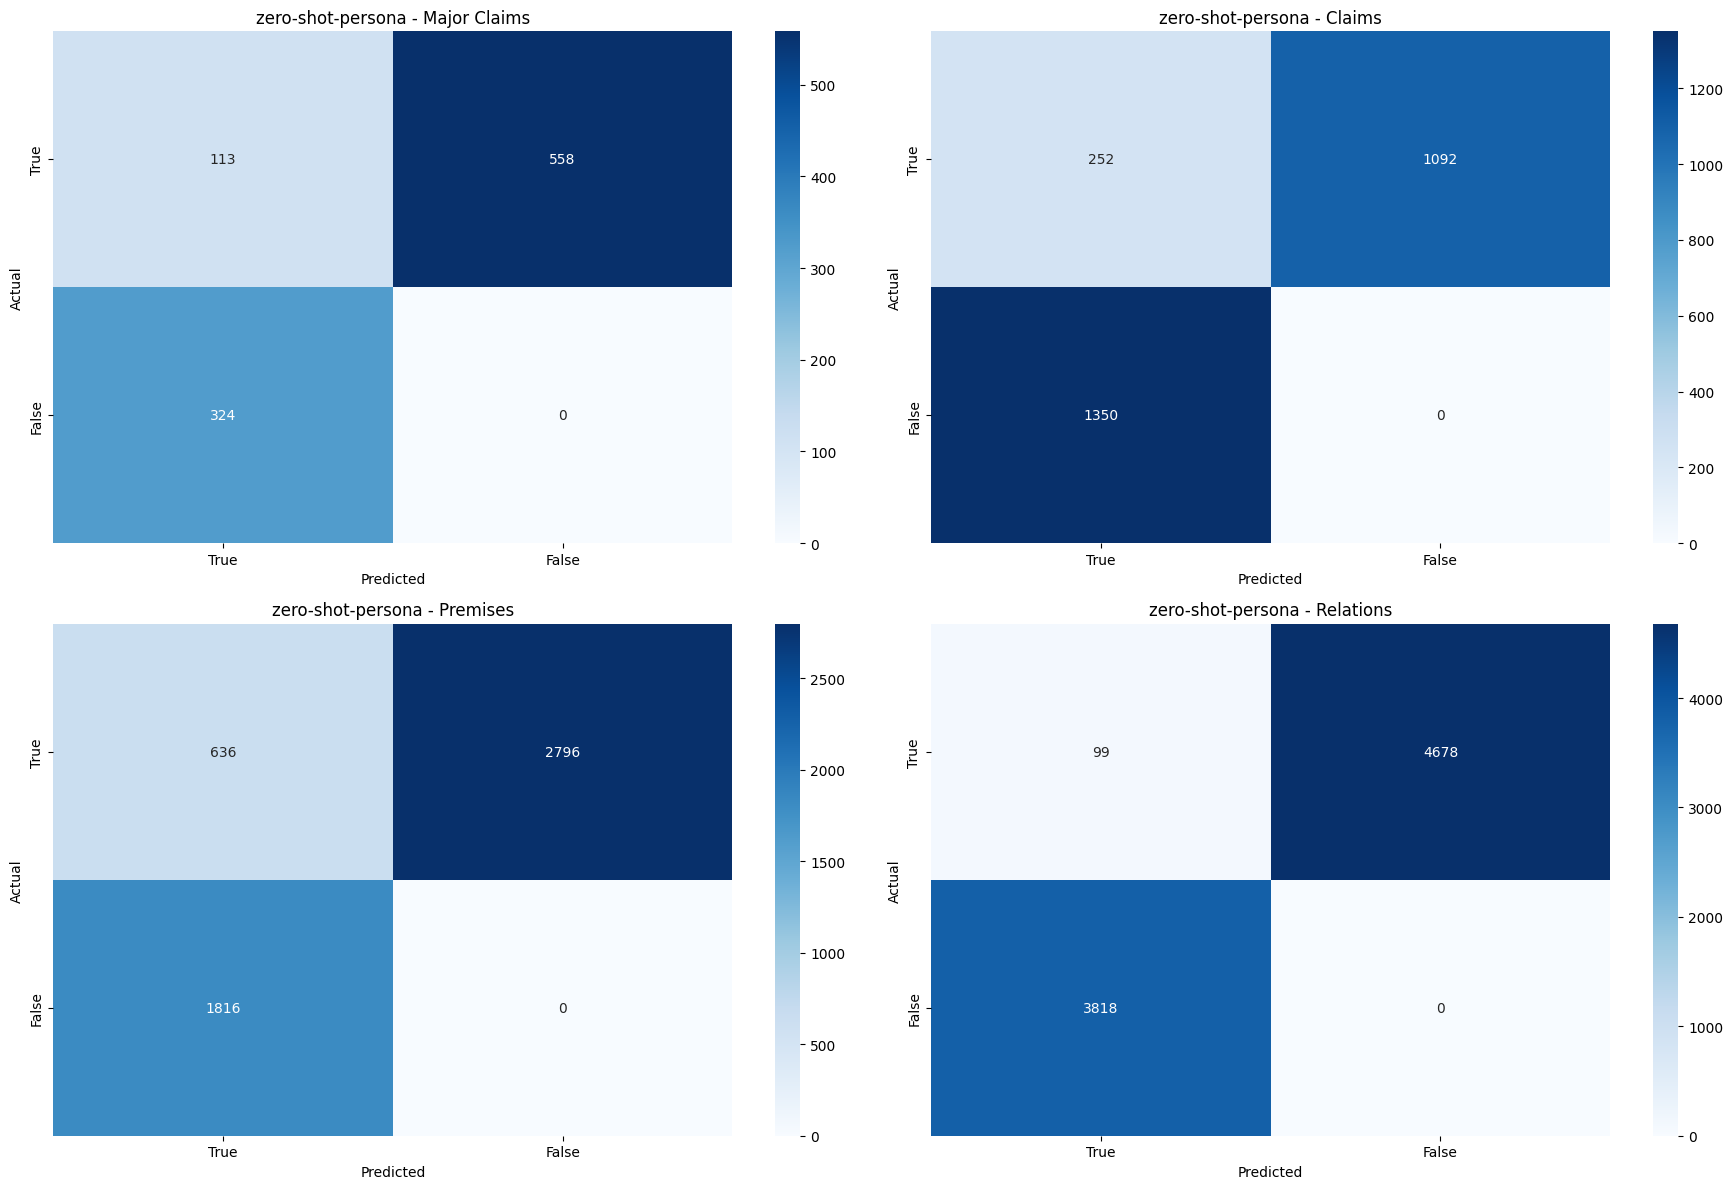

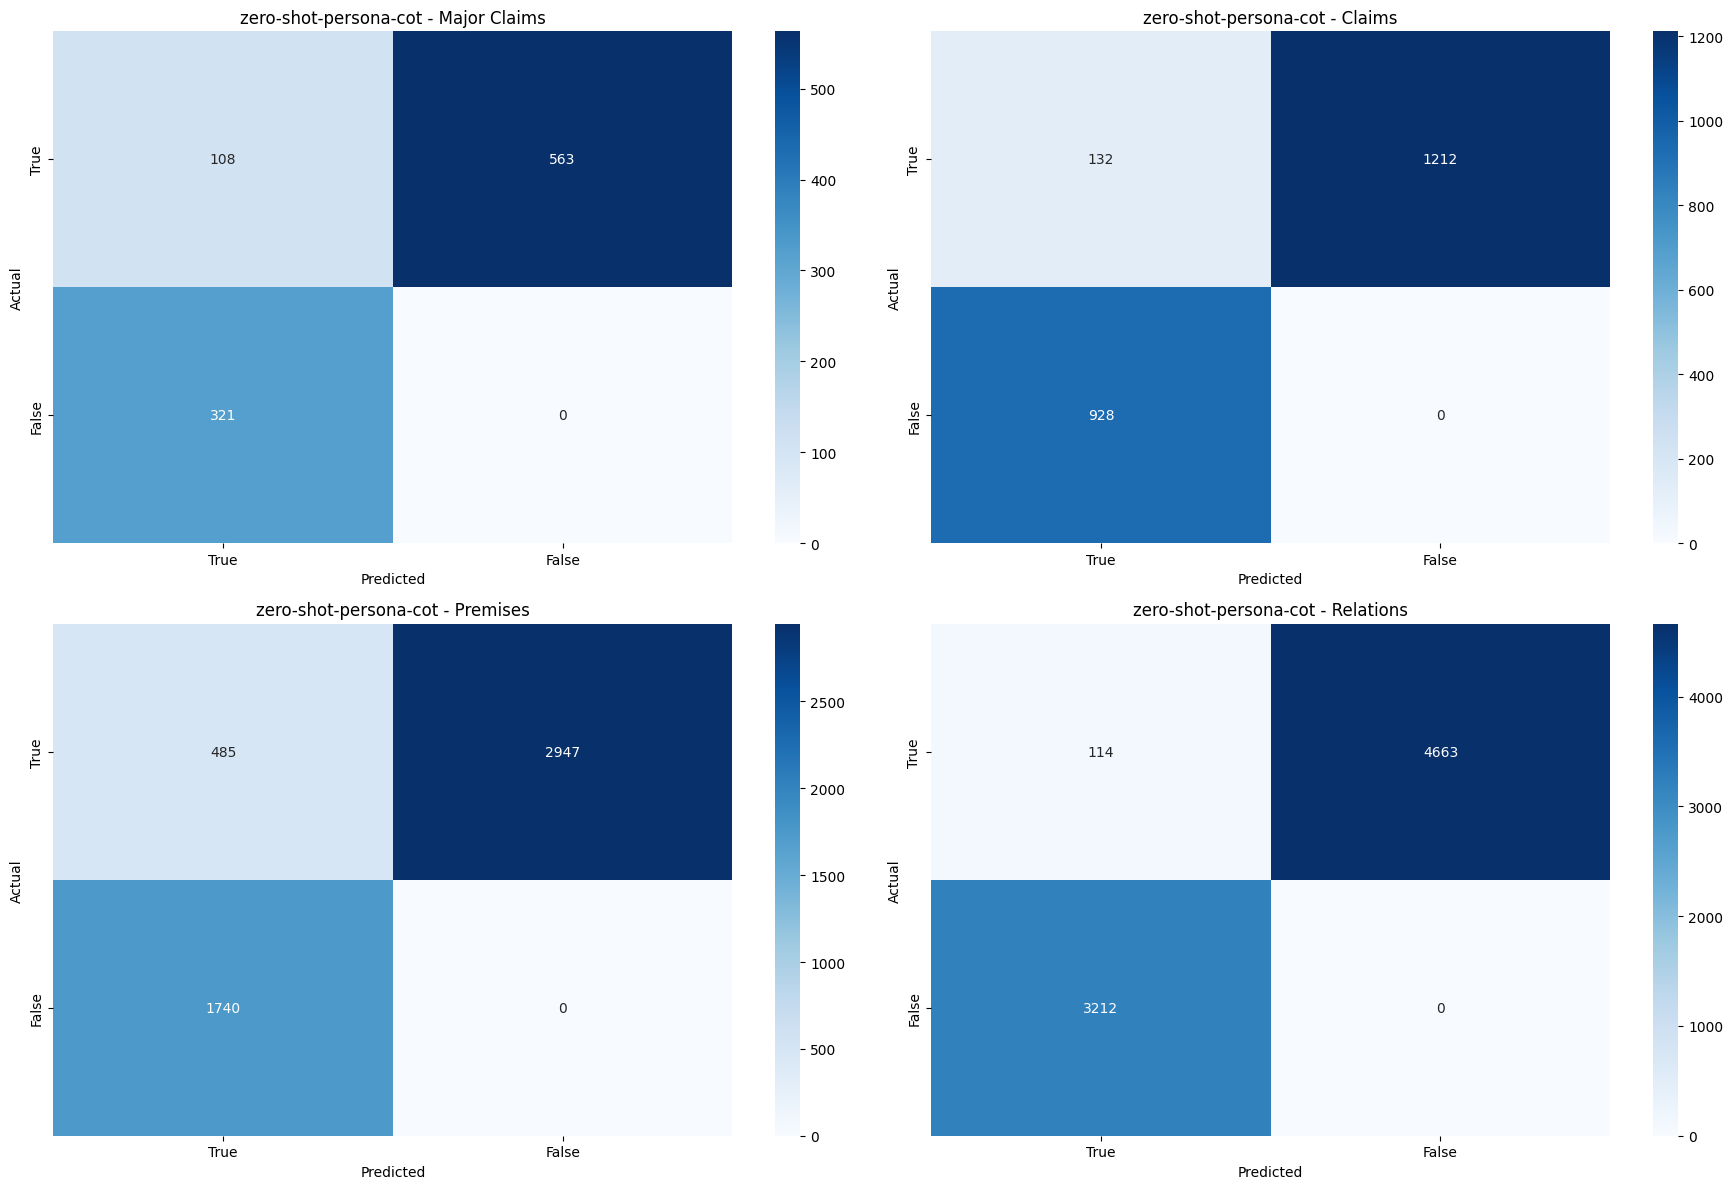

In [33]:
# TODO: Die Berechnungen für Recall, Precision und F1-Score hinzufügen und den return-Wert anpassen
# Calculate the sums for each category
def plot_confusion_matrices(grouped_df):
    for index, row in grouped_df.iterrows():
        total_tp_mc = row['MajorClaims_TP']
        total_fn_mc = row['MajorClaims_FN']
        total_fp_mc = row['MajorClaims_FP']
        total_tn_mc = row['MajorClaims_TN']

        total_tp_c = row['Claims_TP']
        total_fn_c = row['Claims_FN']
        total_fp_c = row['Claims_FP']
        total_tn_c = row['Claims_TN']

        total_tp_p = row['Premises_TP']
        total_fn_p = row['Premises_FN']
        total_fp_p = row['Premises_FP']
        total_tn_p = row['Premises_TN']

        total_tp_r = row['Relations_TP']
        total_fn_r = row['Relations_FN']
        total_fp_r = row['Relations_FP']
        total_tn_r = row['Relations_TN']

        # Create confusion matrices
        confusion_matrix_mc = [[total_tp_mc, total_fn_mc], [total_fp_mc, total_tn_mc]]
        confusion_matrix_c = [[total_tp_c, total_fn_c], [total_fp_c, total_tn_c]]
        confusion_matrix_p = [[total_tp_p, total_fn_p], [total_fp_p, total_tn_p]]
        confusion_matrix_r = [[total_tp_r, total_fn_r], [total_fp_r, total_tn_r]]

        # Plot confusion matrices
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))

        sns.heatmap(confusion_matrix_mc, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
        axes[0, 0].set_title(f'{index} - Major Claims')
        axes[0, 0].set_xlabel('Predicted')
        axes[0, 0].set_ylabel('Actual')
        axes[0, 0].set_xticklabels(['True', 'False'])
        axes[0, 0].set_yticklabels(['True', 'False'])

        sns.heatmap(confusion_matrix_c, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
        axes[0, 1].set_title(f'{index} - Claims')
        axes[0, 1].set_xlabel('Predicted')
        axes[0, 1].set_ylabel('Actual')
        axes[0, 1].set_xticklabels(['True', 'False'])
        axes[0, 1].set_yticklabels(['True', 'False'])

        sns.heatmap(confusion_matrix_p, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
        axes[1, 0].set_title(f'{index} - Premises')
        axes[1, 0].set_xlabel('Predicted')
        axes[1, 0].set_ylabel('Actual')
        axes[1, 0].set_xticklabels(['True', 'False'])
        axes[1, 0].set_yticklabels(['True', 'False'])

        sns.heatmap(confusion_matrix_r, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
        axes[1, 1].set_title(f'{index} - Relations')
        axes[1, 1].set_xlabel('Predicted')
        axes[1, 1].set_ylabel('Actual')
        axes[1, 1].set_xticklabels(['True', 'False'])
        axes[1, 1].set_yticklabels(['True', 'False'])

        plt.tight_layout()
        plt.show()

# Call the function
plot_confusion_matrices(grouped_df)

In [34]:
# count_major_claims_truth = len(zs_df['major_claims_truth'].values[0])
# count_major_claims_zs = len(zs_df['major_claims_llm'].values[0])
# count_claims_truth = len(zs_df['claims_truth'].values[0])
# count_claims_zs = len(zs_df['claims_llm'].values[0])
# count_premises_truth = len(zs_df['premises_truth'].values[0])
# count_premises_zs = len(zs_df['premises_llm'].values[0])
# count_relations_truth = len(zs_df['relations_truth'].values[0])
# count_relations_zs = len(zs_df['relations_llm'].values[0])

# print(f"Major Claims (Ground Truth): {count_major_claims_truth} + Major Claims (Output): {count_major_claims_zs} = {count_major_claims_truth + count_major_claims_zs}")
# print(f"Claims (Ground Truth): {count_claims_truth} + Claims (Output): {count_claims_zs} = {count_claims_truth + count_claims_zs}")
# print(f"Premises (Ground Truth): {count_premises_truth} + Premises (Output): {count_premises_zs} = {count_premises_truth + count_premises_zs}")
# print(f"Relations (Ground Truth): {count_relations_truth} + Relations (Output): {count_relations_zs} = {count_relations_truth + count_relations_zs}")

ggf. liegt es am falschen zuordnen der Dateien? Bspw. bei essay001 passt die Ausgabe inhaltlich überhaupt nicht zum Text.

# Evaluationsmetriken

In [35]:
def calc_mertics(grouped_df):
    eval_metrics = []

    for index, row in grouped_df.iterrows():
        total_tp_mc = row['MajorClaims_TP']
        total_fn_mc = row['MajorClaims_FN']
        total_fp_mc = row['MajorClaims_FP']
        #total_tn_mc = row['MajorClaims_TN']

        total_tp_c = row['Claims_TP']
        total_fn_c = row['Claims_FN']
        total_fp_c = row['Claims_FP']
        #total_tn_c = row['Claims_TN']

        total_tp_p = row['Premises_TP']
        total_fn_p = row['Premises_FN']
        total_fp_p = row['Premises_FP']
        #total_tn_p = row['Premises_TN']

        total_tp_r = row['Relations_TP']
        total_fn_r = row['Relations_FN']
        total_fp_r = row['Relations_FP']
        #total_tn_r = row['Relations_TN']

        # Calculate Precision, Recall, and F1-Score for Major Claims
        precision_mc = total_tp_mc / (total_tp_mc + total_fp_mc) if (total_tp_mc + total_fp_mc) != 0 else 0
        recall_mc = total_tp_mc / (total_tp_mc + total_fn_mc) if (total_tp_mc + total_fn_mc) != 0 else 0
        f1_score_mc = 2 * (precision_mc * recall_mc) / (precision_mc + recall_mc) if (precision_mc + recall_mc) != 0 else 0

        # Calculate Precision, Recall, and F1-Score for Claims
        precision_c = total_tp_c / (total_tp_c + total_fp_c) if (total_tp_c + total_fp_c) != 0 else 0
        recall_c = total_tp_c / (total_tp_c + total_fn_c) if (total_tp_c + total_fn_c) != 0 else 0
        f1_score_c = 2 * (precision_c * recall_c) / (precision_c + recall_c) if (precision_c + recall_c) != 0 else 0
        
        # Calculate Precision, Recall, and F1-Score for Premises
        precision_p = total_tp_p / (total_tp_p + total_fp_p) if (total_tp_p + total_fp_p) != 0 else 0
        recall_p = total_tp_p / (total_tp_p + total_fn_p) if (total_tp_p + total_fn_p) != 0 else 0
        f1_score_p = 2 * (precision_p * recall_p) / (precision_p + recall_p) if (precision_p + recall_p) != 0 else 0

        # Calculate Precision, Recall, and F1-Score for Relations
        precision_r = total_tp_r / (total_tp_r + total_fp_r) if (total_tp_r + total_fp_r) != 0 else 0
        recall_r = total_tp_r / (total_tp_r + total_fn_r) if (total_tp_r + total_fn_r) != 0 else 0
        f1_score_r = 2 * (precision_r * recall_r) / (precision_r + recall_r) if (precision_r + recall_r) != 0 else 0


        eval_metrics.append({
            'Prompt': index,
            'Precision_MC': round(precision_mc, 2),
            'Recall_MC': round(recall_mc, 2),
            'F1_Score_MC': round(f1_score_mc, 2),
            'Precision_C': round(precision_c, 2),
            'Recall_C': round(recall_c, 2),
            'F1_Score_C': round(f1_score_c, 2),
            'Precision_P': round(precision_p, 2),
            'Recall_P': round(recall_p, 2),
            'F1_Score_P': round(f1_score_p, 2),
            'Precision_R': round(precision_r, 2),
            'Recall_R': round(recall_r, 2),
            'F1_Score_R': round(f1_score_r, 2)
        })
    
    df = pd.DataFrame(eval_metrics)

    return df

In [36]:
def calc_mertics2(input_df):
    eval_metrics = []

    for index, row in input_df.iterrows():
        total_tp_mc = row['MajorClaims_TP']
        total_fn_mc = row['MajorClaims_FN']
        total_fp_mc = row['MajorClaims_FP']
        #total_tn_mc = row['MajorClaims_TN']

        total_tp_c = row['Claims_TP']
        total_fn_c = row['Claims_FN']
        total_fp_c = row['Claims_FP']
        #total_tn_c = row['Claims_TN']

        total_tp_p = row['Premises_TP']
        total_fn_p = row['Premises_FN']
        total_fp_p = row['Premises_FP']
        #total_tn_p = row['Premises_TN']

        total_tp_r = row['Relations_TP']
        total_fn_r = row['Relations_FN']
        total_fp_r = row['Relations_FP']
        #total_tn_r = row['Relations_TN']

        # Calculate Precision, Recall, and F1-Score for Major Claims
        precision_mc = total_tp_mc / (total_tp_mc + total_fp_mc) if (total_tp_mc + total_fp_mc) != 0 else 0
        recall_mc = total_tp_mc / (total_tp_mc + total_fn_mc) if (total_tp_mc + total_fn_mc) != 0 else 0
        f1_score_mc = 2 * (precision_mc * recall_mc) / (precision_mc + recall_mc) if (precision_mc + recall_mc) != 0 else 0

        # Calculate Precision, Recall, and F1-Score for Claims
        precision_c = total_tp_c / (total_tp_c + total_fp_c) if (total_tp_c + total_fp_c) != 0 else 0
        recall_c = total_tp_c / (total_tp_c + total_fn_c) if (total_tp_c + total_fn_c) != 0 else 0
        f1_score_c = 2 * (precision_c * recall_c) / (precision_c + recall_c) if (precision_c + recall_c) != 0 else 0
        
        # Calculate Precision, Recall, and F1-Score for Premises
        precision_p = total_tp_p / (total_tp_p + total_fp_p) if (total_tp_p + total_fp_p) != 0 else 0
        recall_p = total_tp_p / (total_tp_p + total_fn_p) if (total_tp_p + total_fn_p) != 0 else 0
        f1_score_p = 2 * (precision_p * recall_p) / (precision_p + recall_p) if (precision_p + recall_p) != 0 else 0

        # Calculate Precision, Recall, and F1-Score for Relations
        precision_r = total_tp_r / (total_tp_r + total_fp_r) if (total_tp_r + total_fp_r) != 0 else 0
        recall_r = total_tp_r / (total_tp_r + total_fn_r) if (total_tp_r + total_fn_r) != 0 else 0
        f1_score_r = 2 * (precision_r * recall_r) / (precision_r + recall_r) if (precision_r + recall_r) != 0 else 0


        eval_metrics.append({
            'Prompt': row['prompt'],
            'Precision_MC': round(precision_mc, 2),
            'Recall_MC': round(recall_mc, 2),
            'F1_Score_MC': round(f1_score_mc, 2),
            'Precision_C': round(precision_c, 2),
            'Recall_C': round(recall_c, 2),
            'F1_Score_C': round(f1_score_c, 2),
            'Precision_P': round(precision_p, 2),
            'Recall_P': round(recall_p, 2),
            'F1_Score_P': round(f1_score_p, 2),
            'Precision_R': round(precision_r, 2),
            'Recall_R': round(recall_r, 2),
            'F1_Score_R': round(f1_score_r, 2),
        })
    
    df = pd.DataFrame(eval_metrics)

    return df

# example

In [37]:
PROMPTS_PATH = 'prompts/final-prompts/'

prompt_files_directory_list = list_files_with_extension_directory(PROMPTS_PATH, '.txt')
prompt_files_directory_list
prompt_files_list = [os.path.basename(x) for x in prompt_files_directory_list]
# remove the .txt extension
prompt_names = [x.split('.')[0] for x in prompt_files_list]

token_df = pd.DataFrame()
# get the file name without the extension from prompt_files, 'str' object has no attribute 'path'
token_df['Prompt'] = prompt_names
token_df['prompt_txt'] = prompt_files_directory_list
token_df['prompt_txt'] = token_df['prompt_txt'].apply(load_text)
token_df['tokens'] = token_df['prompt_txt'].apply(num_tokens_from_string, model_name='gpt-4o-mini')
token_df = token_df.drop(columns=['prompt_txt'])
token_df = token_df.sort_values(by='tokens')
token_df

,Prompt,tokens
19,zero-shot,82
18,zero-shot-persona,105
16,zero-shot-cot,480
17,zero-shot-persona-cot,503
15,one-shot,1780
14,one-shot-persona,1790
12,one-shot-cot,2166
13,one-shot-persona-cot,2189
3,few-shot-10,13848
2,few-shot-10-persona,13871


## textweise

In [38]:
#merged_eval_df.columns
#merged_eval_df.head()
#eval_metric_df = calc_mertics2(merged_eval_df)
#eval_metric_df.columns

In [39]:
eval_metric_df = calc_mertics2(merged_eval_df)
eval_metric_df.columns

Index(['Prompt', 'Precision_MC', 'Recall_MC', 'F1_Score_MC', 'Precision_C',
       'Recall_C', 'F1_Score_C', 'Precision_P', 'Recall_P', 'F1_Score_P',
       'Precision_R', 'Recall_R', 'F1_Score_R'],
      dtype='object')

In [40]:
#use merge to add the token count to the eval_metric_df
eval_metric_df = pd.merge(eval_metric_df, token_df, on='Prompt')
print(eval_metric_df.shape)

(5865, 14)


In [41]:
eval_metric_df.sample(5, random_state=42)

,Prompt,Precision_MC,Recall_MC,F1_Score_MC,Precision_C,Recall_C,F1_Score_C,Precision_P,Recall_P,F1_Score_P,Precision_R,Recall_R,F1_Score_R,tokens
3482,zero-shot-persona,0.0,0.0,0.0,0.12,0.25,0.17,0.17,0.25,0.20,0.00,0.00,0.00,105
3424,one-shot-persona-cot,0.0,0.0,0.0,0.29,0.67,0.40,0.44,0.57,0.50,0.14,0.20,0.17,2189
199,few-shot-20,1.0,1.0,1.0,0.33,0.25,0.29,0.25,0.22,0.24,0.00,0.00,0.00,27681
439,few-shot-20-cot,1.0,1.0,1.0,0.33,0.40,0.36,1.00,0.57,0.73,0.30,0.25,0.27,28080
4550,few-shot-20-persona,0.5,0.5,0.5,0.50,0.40,0.44,0.67,0.40,0.50,0.23,0.15,0.18,27704


## gruppiert nach prompt-art

In [42]:
grouped_eval_metric_df = calc_mertics(grouped_df)
# merge the eval_metric_df with token_df
grouped_eval_metric_df = pd.merge(grouped_eval_metric_df, token_df, on='Prompt')
grouped_eval_metric_df = grouped_eval_metric_df.sort_values(by='tokens')
grouped_eval_metric_df

,Prompt,Precision_MC,Recall_MC,F1_Score_MC,Precision_C,Recall_C,F1_Score_C,Precision_P,Recall_P,F1_Score_P,Precision_R,Recall_R,F1_Score_R,tokens
13,zero-shot,0.24,0.15,0.19,0.13,0.13,0.13,0.21,0.13,0.16,0.02,0.01,0.01,82
15,zero-shot-persona,0.26,0.17,0.20,0.16,0.19,0.17,0.26,0.19,0.22,0.03,0.02,0.02,105
14,zero-shot-cot,0.22,0.14,0.17,0.09,0.07,0.08,0.14,0.09,0.11,0.02,0.01,0.01,480
16,zero-shot-persona-cot,0.25,0.16,0.20,0.12,0.10,0.11,0.22,0.14,0.17,0.03,0.02,0.03,503
9,one-shot,0.42,0.45,0.44,0.21,0.41,0.28,0.40,0.25,0.31,0.09,0.09,0.09,1780
11,one-shot-persona,0.45,0.43,0.44,0.21,0.44,0.29,0.45,0.28,0.34,0.11,0.11,0.11,1790
10,one-shot-cot,0.43,0.45,0.44,0.21,0.38,0.27,0.40,0.26,0.31,0.08,0.08,0.08,2166
12,one-shot-persona-cot,0.45,0.48,0.46,0.21,0.41,0.28,0.45,0.28,0.35,0.10,0.10,0.10,2189
0,few-shot-10,0.50,0.55,0.52,0.26,0.38,0.31,0.51,0.31,0.39,0.12,0.10,0.11,13848
2,few-shot-10-persona,0.52,0.55,0.54,0.26,0.40,0.31,0.54,0.32,0.41,0.13,0.11,0.12,13871


In [43]:
zs_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("zero-shot")]
os_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("one-shot")]
fs10_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("few-shot-10")]
fs20_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("few-shot-20")]
fs40_eval_metric_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].str.contains("few-shot-40")]

zs_mean_tokens= round(zs_eval_metric_df['tokens'].mean(), 0)
os_mean_tokens= round(os_eval_metric_df['tokens'].mean(), 0)
fs10_mean_tokens= round(fs10_eval_metric_df['tokens'].mean(), 0)
fs20_mean_tokens= round(fs20_eval_metric_df['tokens'].mean(), 0)
fs40_mean_tokens= round(fs40_eval_metric_df['tokens'].mean(), 0)

print(f"Zero-Shot Mean Tokens: {zs_mean_tokens}")
print(f"One-Shot Mean Tokens: {os_mean_tokens}")
print(f"Few-Shot 10 Mean Tokens: {fs10_mean_tokens}")
print(f"Few-Shot 20 Mean Tokens: {fs20_mean_tokens}")
print(f"Few-Shot 40 Mean Tokens: {fs40_mean_tokens}")

Zero-Shot Mean Tokens: 292.0
One-Shot Mean Tokens: 1981.0
Few-Shot 10 Mean Tokens: 14059.0
Few-Shot 20 Mean Tokens: 27892.0
Few-Shot 40 Mean Tokens: 54048.0


In [44]:
#TODO: Listen erweitern, sobald die Ergebnisse vorliegen
basic_list = ['zero-shot', 'one-shot', 'few-shot-10', 'few-shot-20', 'few-shot-40']
persona_list = ['zero-shot-persona', 'one-shot-persona', 'few-shot-10-persona', 'few-shot-20-persona']#, 'few-shot-40-persona']
cot_list = ['zero-shot-cot', 'one-shot-cot', 'few-shot-10-cot', 'few-shot-20-cot' ] #, 'few-shot-40-cot
persona_cot_list = ['zero-shot-persona-cot', 'one-shot-persona-cot', 'few-shot-10-persona-cot', 'few-shot-20-persona-cot'] #, 'few-shot-40-persona-cot']

# filter the eval_metric_df by the persona_cot_list
eval_metric_basic_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].isin(basic_list)]
eval_metric_persona_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].isin(persona_list)]
eval_metric_cot_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].isin(cot_list)]
eval_metric_persona_cot_df = grouped_eval_metric_df[grouped_eval_metric_df['Prompt'].isin(persona_cot_list)]

print(len(eval_metric_basic_df))
print(len(eval_metric_persona_df))
print(len(eval_metric_cot_df))
print(len(eval_metric_persona_cot_df))

5
4
4
4


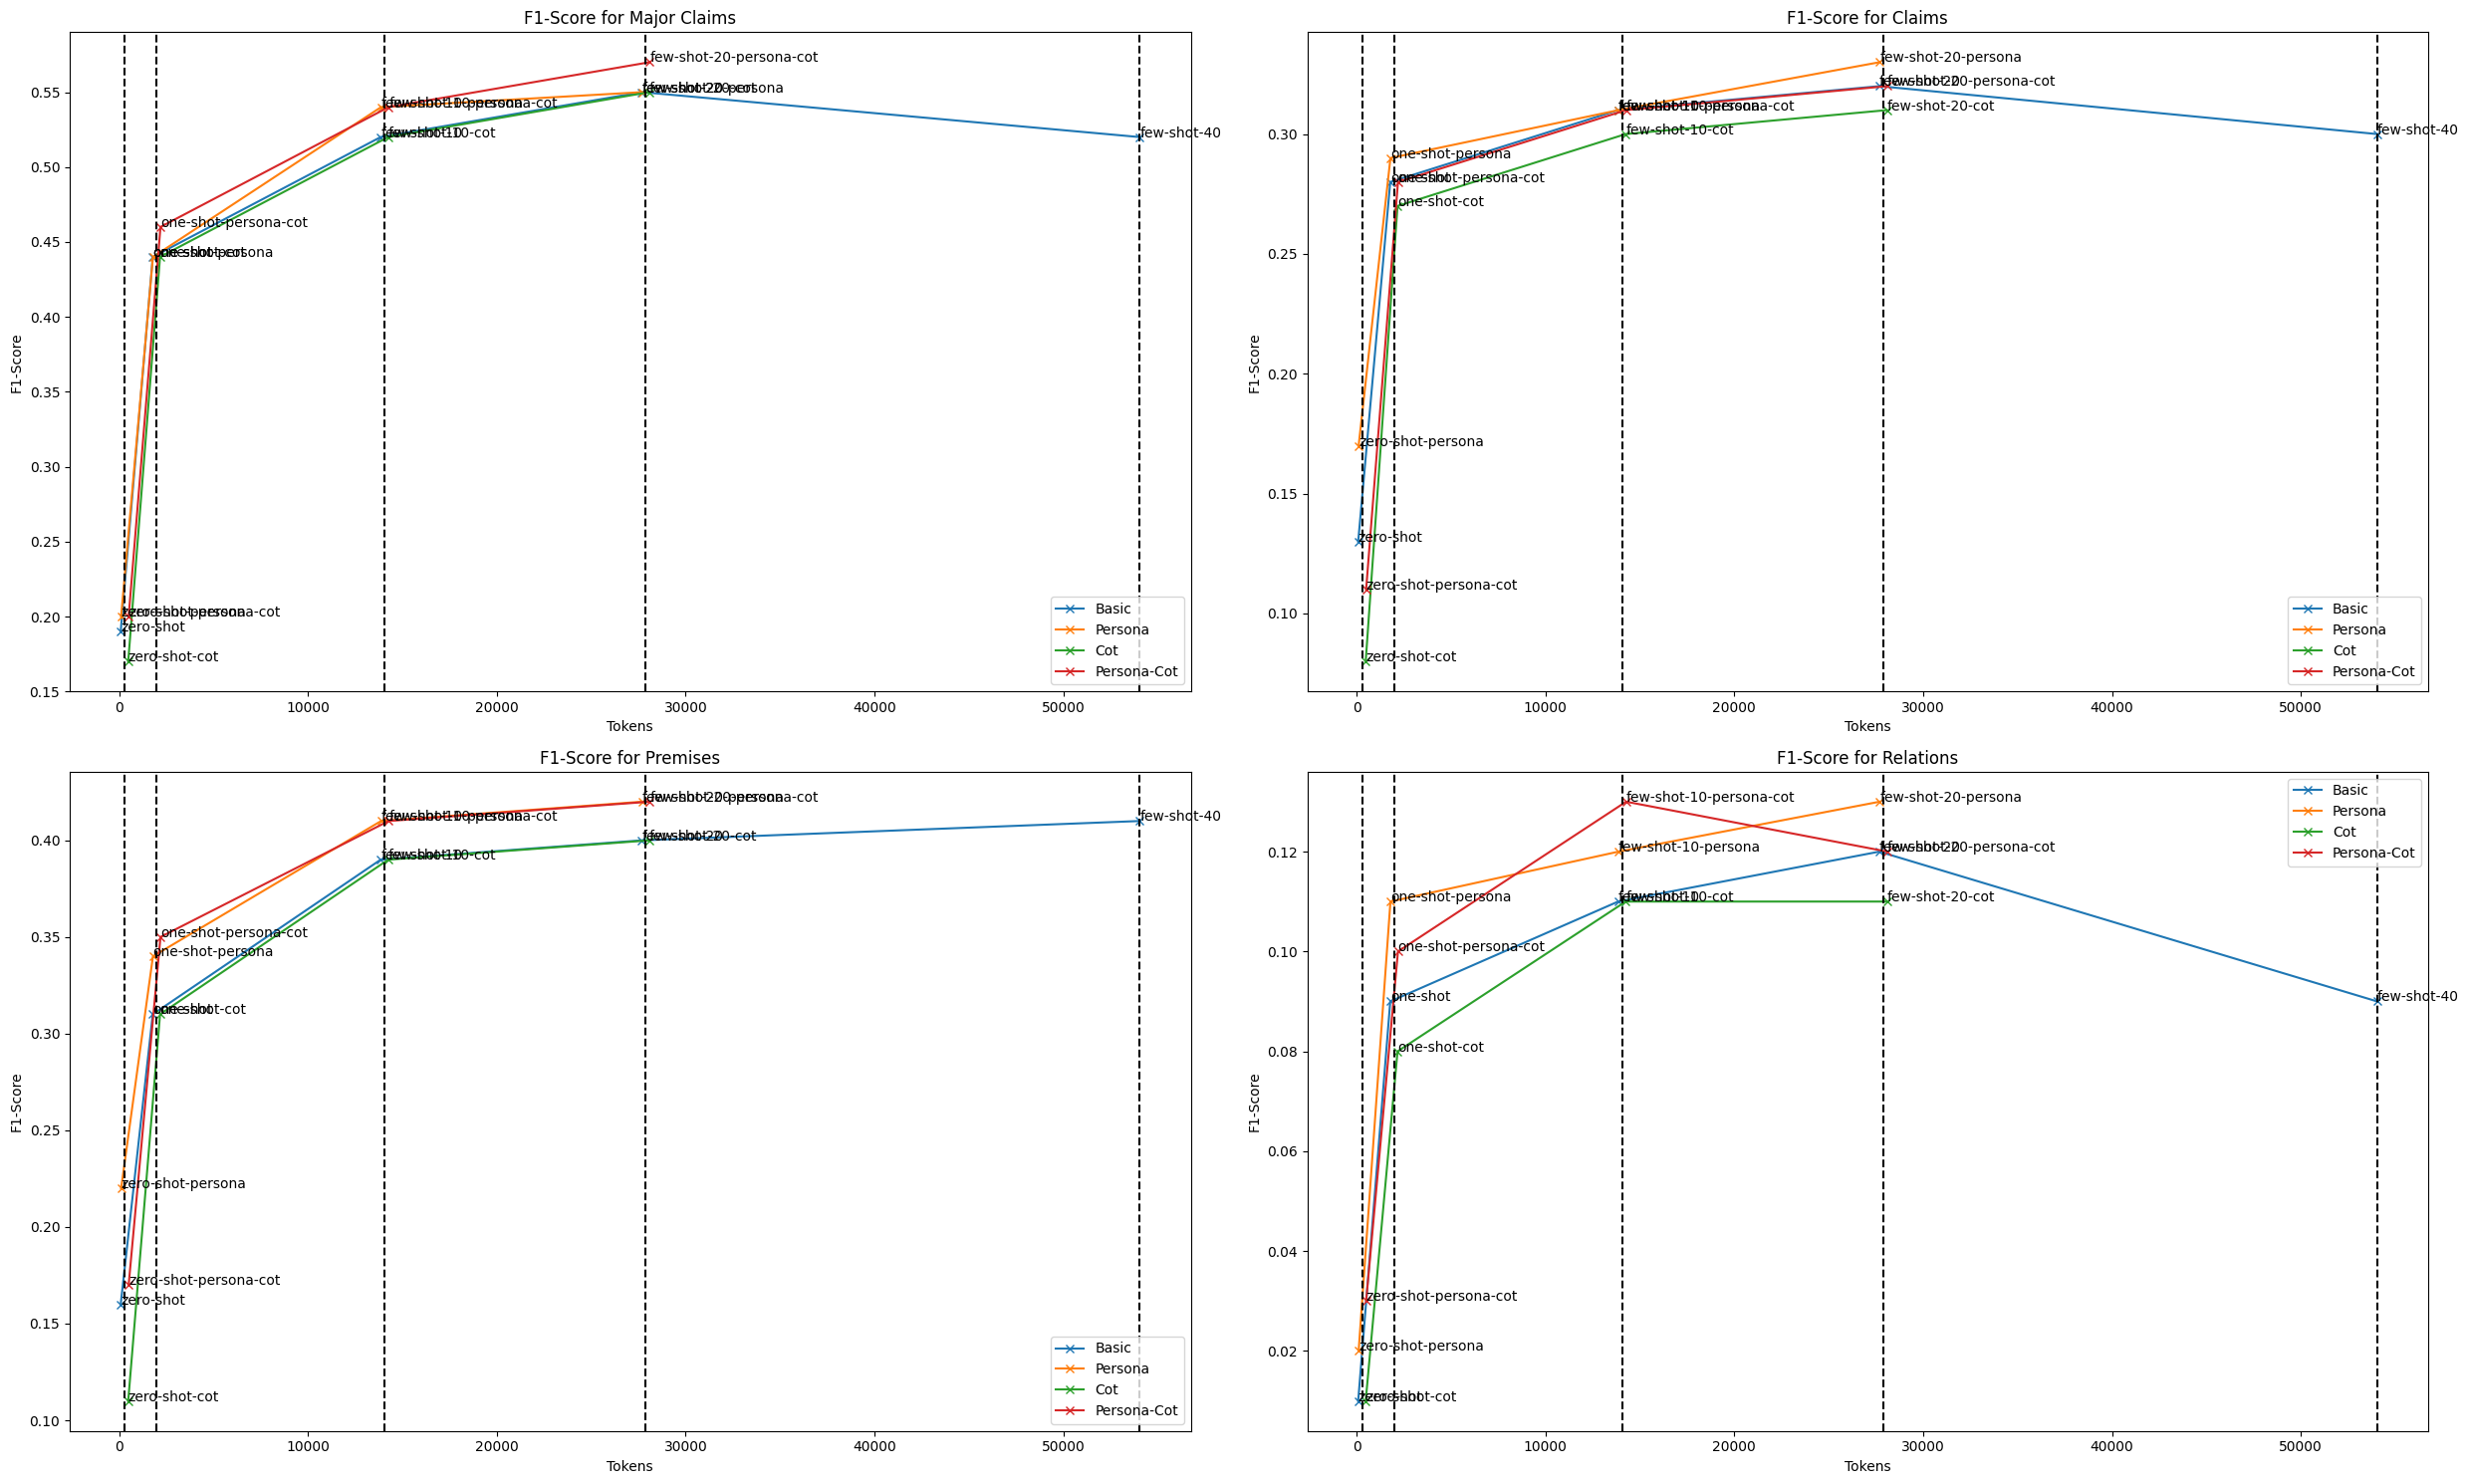

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(25, 15))
plt.annotate
# Plot for Major Claims
axs[0, 0].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_MC'], label='Basic', marker='x')
axs[0, 0].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_MC'], label='Persona', marker='x')
axs[0, 0].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_MC'], label='Cot', marker='x')
axs[0, 0].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_MC'], label='Persona-Cot', marker='x')

axs[0, 0].set_xlabel('Tokens')
axs[0, 0].set_ylabel('F1-Score')
axs[0, 0].set_title('F1-Score for Major Claims')
axs[0, 0].legend()
# Beschriftungen für die Punkte
for idx, row in eval_metric_basic_df.iterrows():
    axs[0, 0].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_MC']), xytext=(row['tokens'], row['F1_Score_MC']))
for idx, row in eval_metric_persona_df.iterrows():
    axs[0, 0].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_MC']), xytext=(row['tokens'], row['F1_Score_MC']))
for idx, row in eval_metric_cot_df.iterrows():
    axs[0, 0].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_MC']), xytext=(row['tokens'], row['F1_Score_MC']))
for idx, row in eval_metric_persona_cot_df.iterrows():
    axs[0, 0].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_MC']), xytext=(row['tokens'], row['F1_Score_MC']))
# Vertikale Linien
axs[0, 0].axvline(x=zs_mean_tokens, color='black', linestyle='--', label='Zero-shot Mean Tokens')
axs[0, 0].annotate('ZS', xy=(zs_mean_tokens, 0), xytext=(zs_mean_tokens, 0.5))
axs[0, 0].axvline(x=os_mean_tokens, color='black', linestyle='--', label='One-shot Mean Tokens')
axs[0, 0].annotate('OS', xy=(os_mean_tokens, 0), xytext=(os_mean_tokens, 0.5))
axs[0, 0].axvline(x=fs10_mean_tokens, color='black', linestyle='--', label='Few-shot-10 Mean Tokens')
axs[0, 0].annotate('FS10', xy=(fs10_mean_tokens, 0), xytext=(fs10_mean_tokens, 0.5))
axs[0, 0].axvline(x=fs20_mean_tokens, color='black', linestyle='--', label='Few-shot-20 Mean Tokens')
axs[0, 0].annotate('FS20', xy=(fs20_mean_tokens, 0), xytext=(fs20_mean_tokens, 0.5))
axs[0, 0].axvline(x=fs40_mean_tokens, color='black', linestyle='--', label='Few-shot-40 Mean Tokens')
axs[0, 0].annotate('FS40', xy=(fs40_mean_tokens, 0), xytext=(fs40_mean_tokens, 0.5))

# Plot for Claims
axs[0, 1].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_C'], label='Basic', marker='x')
axs[0, 1].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_C'], label='Persona', marker='x')
axs[0, 1].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_C'], label='Cot', marker='x')
axs[0, 1].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_C'], label='Persona-Cot', marker='x')
axs[0, 1].set_xlabel('Tokens')
axs[0, 1].set_ylabel('F1-Score')
axs[0, 1].set_title('F1-Score for Claims')
axs[0, 1].legend()
# Beschriftungen für die Punkte
for idx, row in eval_metric_basic_df.iterrows():
    axs[0, 1].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_C']), xytext=(row['tokens'], row['F1_Score_C']))
for idx, row in eval_metric_persona_df.iterrows():
    axs[0, 1].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_C']), xytext=(row['tokens'], row['F1_Score_C']))
for idx, row in eval_metric_cot_df.iterrows():
    axs[0, 1].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_C']), xytext=(row['tokens'], row['F1_Score_C']))
for idx, row in eval_metric_persona_cot_df.iterrows():
    axs[0, 1].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_C']), xytext=(row['tokens'], row['F1_Score_C']))
# Vertikale Linien
axs[0, 1].axvline(x=zs_mean_tokens, color='black', linestyle='--', label='Zero-shot Mean Tokens')
axs[0, 1].axvline(x=os_mean_tokens, color='black', linestyle='--', label='One-shot Mean Tokens')
axs[0, 1].axvline(x=fs10_mean_tokens, color='black', linestyle='--', label='Few-shot-10 Mean Tokens')
axs[0, 1].axvline(x=fs20_mean_tokens, color='black', linestyle='--', label='Few-shot-20 Mean Tokens')
axs[0, 1].axvline(x=fs40_mean_tokens, color='black', linestyle='--', label='Few-shot-40 Mean Tokens')

# Plot for Premises
axs[1, 0].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_P'], label='Basic', marker='x')
axs[1, 0].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_P'], label='Persona', marker='x')
axs[1, 0].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_P'], label='Cot', marker='x')
axs[1, 0].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_P'], label='Persona-Cot', marker='x')
axs[1, 0].set_xlabel('Tokens')
axs[1, 0].set_ylabel('F1-Score')
axs[1, 0].set_title('F1-Score for Premises')
axs[1, 0].legend()
# Beschriftungen für die Punkte
for idx, row in eval_metric_basic_df.iterrows():
    axs[1, 0].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_P']), xytext=(row['tokens'], row['F1_Score_P']))
for idx, row in eval_metric_persona_df.iterrows():
    axs[1, 0].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_P']), xytext=(row['tokens'], row['F1_Score_P']))    
for idx, row in eval_metric_cot_df.iterrows():
    axs[1, 0].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_P']), xytext=(row['tokens'], row['F1_Score_P']))
for idx, row in eval_metric_persona_cot_df.iterrows():
    axs[1, 0].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_P']), xytext=(row['tokens'], row['F1_Score_P']))
# Vertikale Linien
axs[1, 0].axvline(x=zs_mean_tokens, color='black', linestyle='--', label='Zero-shot Mean Tokens')
axs[1, 0].axvline(x=os_mean_tokens, color='black', linestyle='--', label='One-shot Mean Tokens')
axs[1, 0].axvline(x=fs10_mean_tokens, color='black', linestyle='--', label='Few-shot-10 Mean Tokens')
axs[1, 0].axvline(x=fs20_mean_tokens, color='black', linestyle='--', label='Few-shot-20 Mean Tokens')
axs[1, 0].axvline(x=fs40_mean_tokens, color='black', linestyle='--', label='Few-shot-40 Mean Tokens')

# Plot for Relations
axs[1, 1].plot(eval_metric_basic_df['tokens'], eval_metric_basic_df['F1_Score_R'], label='Basic', marker='x')
axs[1, 1].plot(eval_metric_persona_df['tokens'], eval_metric_persona_df['F1_Score_R'], label='Persona', marker='x')
axs[1, 1].plot(eval_metric_cot_df['tokens'], eval_metric_cot_df['F1_Score_R'], label='Cot', marker='x')
axs[1, 1].plot(eval_metric_persona_cot_df['tokens'], eval_metric_persona_cot_df['F1_Score_R'], label='Persona-Cot', marker='x')
axs[1, 1].set_xlabel('Tokens')
axs[1, 1].set_ylabel('F1-Score')
axs[1, 1].set_title('F1-Score for Relations')
axs[1, 1].legend()
# Beschriftungen für die Punkte
for idx, row in eval_metric_basic_df.iterrows():
    axs[1, 1].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_R']), xytext=(row['tokens'], row['F1_Score_R']))
for idx, row in eval_metric_persona_df.iterrows():
    axs[1, 1].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_R']), xytext=(row['tokens'], row['F1_Score_R']))
for idx, row in eval_metric_cot_df.iterrows():
    axs[1, 1].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_R']), xytext=(row['tokens'], row['F1_Score_R']))
for idx, row in eval_metric_persona_cot_df.iterrows():
    axs[1, 1].annotate(text=row['Prompt'], xy=(row['tokens'], row['F1_Score_R']), xytext=(row['tokens'], row['F1_Score_R']))
# Vertikale Linien
axs[1, 1].axvline(x=zs_mean_tokens, color='black', linestyle='--', label='Zero-shot Mean Tokens')
axs[1, 1].axvline(x=os_mean_tokens, color='black', linestyle='--', label='One-shot Mean Tokens')
axs[1, 1].axvline(x=fs10_mean_tokens, color='black', linestyle='--', label='Few-shot-10 Mean Tokens')
axs[1, 1].axvline(x=fs20_mean_tokens, color='black', linestyle='--', label='Few-shot-20 Mean Tokens')
axs[1, 1].axvline(x=fs40_mean_tokens, color='black', linestyle='--', label='Few-shot-40 Mean Tokens')

plt.tight_layout()
plt.show()

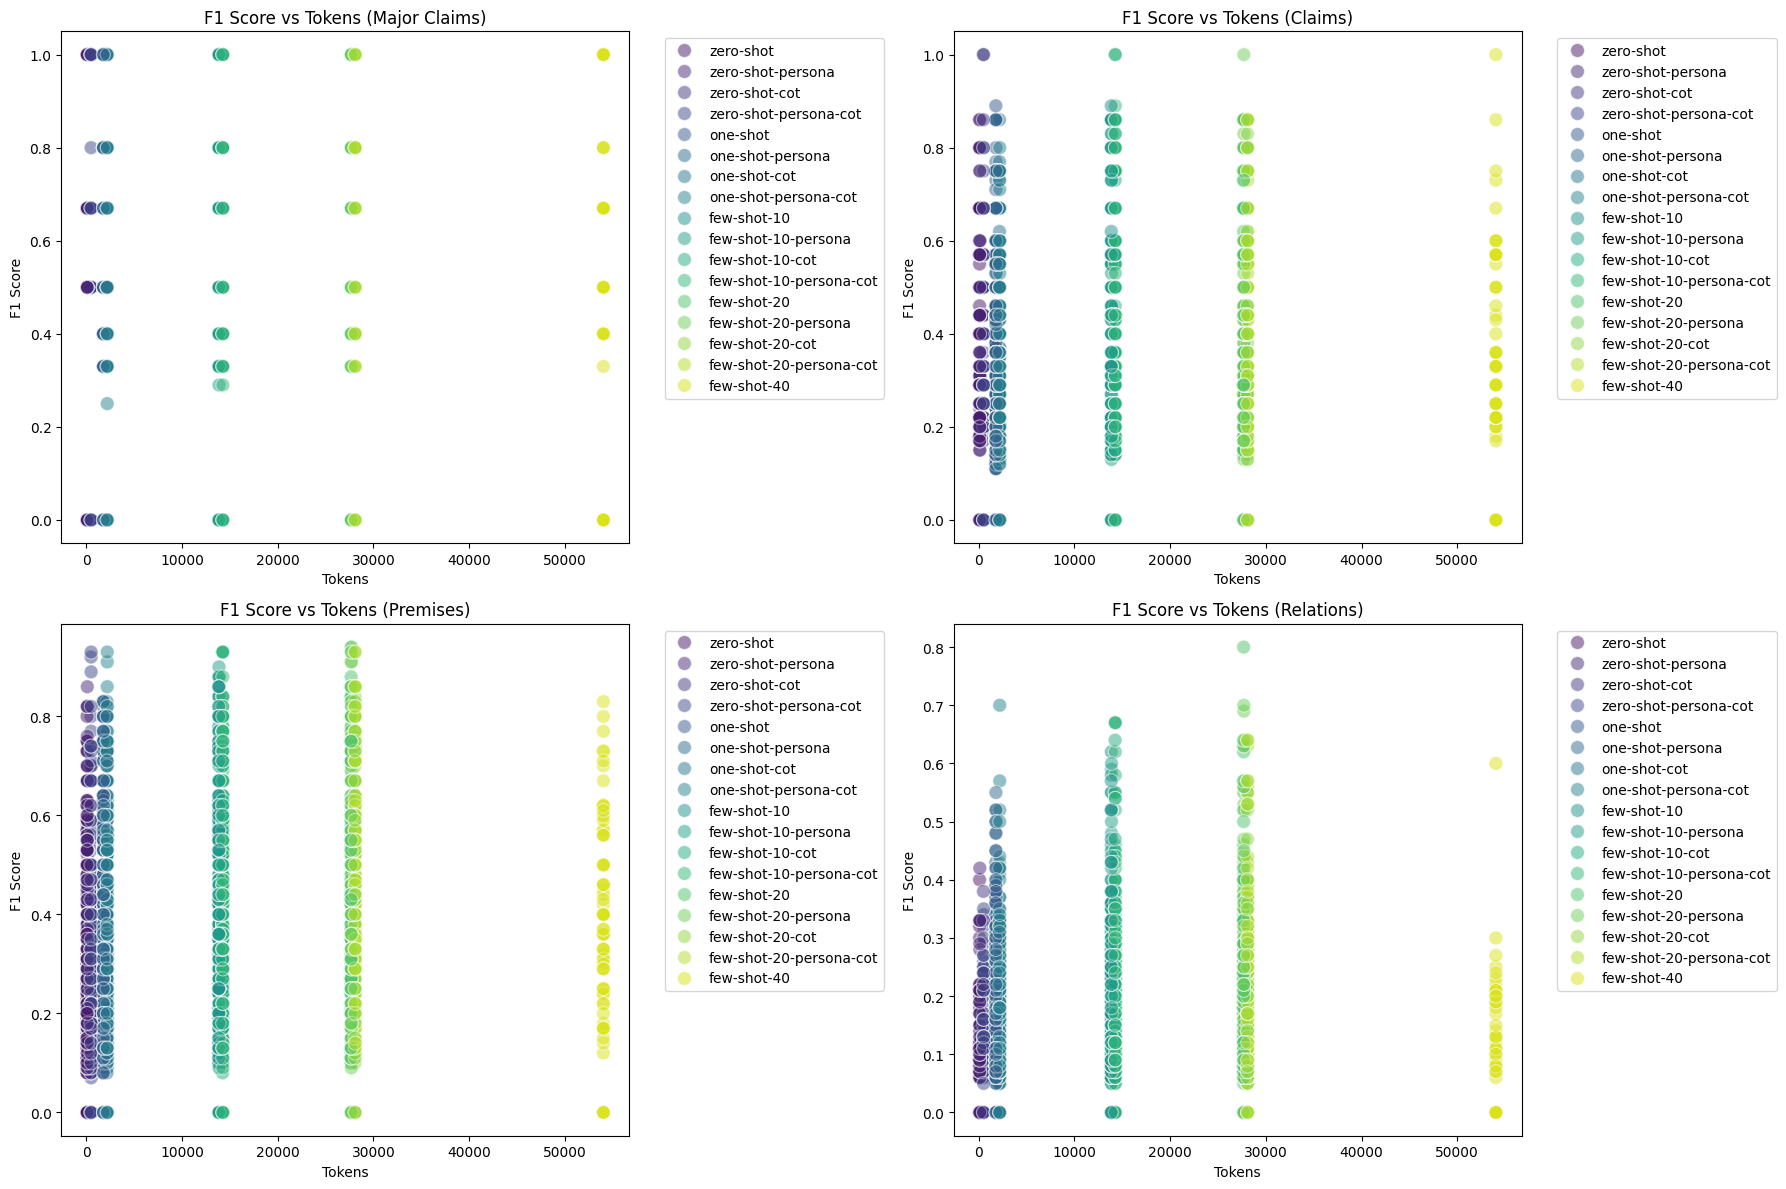

In [46]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a scatter plot
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Plot for Major Claims
sns.scatterplot(data=eval_metric_df, x='tokens', y='F1_Score_MC', hue='Prompt', palette='viridis', s=100, ax=axs[0, 0], alpha=0.5)
axs[0, 0].set_title('F1 Score vs Tokens (Major Claims)')
axs[0, 0].set_xlabel('Tokens')
axs[0, 0].set_ylabel('F1 Score')
axs[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for Claims
sns.scatterplot(data=eval_metric_df, x='tokens', y='F1_Score_C', hue='Prompt', palette='viridis', s=100, ax=axs[0, 1], alpha=0.5)
axs[0, 1].set_title('F1 Score vs Tokens (Claims)')
axs[0, 1].set_xlabel('Tokens')
axs[0, 1].set_ylabel('F1 Score')
axs[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for Premises
sns.scatterplot(data=eval_metric_df, x='tokens', y='F1_Score_P', hue='Prompt', palette='viridis', s=100, ax=axs[1, 0], alpha=0.5)
axs[1, 0].set_title('F1 Score vs Tokens (Premises)')
axs[1, 0].set_xlabel('Tokens')
axs[1, 0].set_ylabel('F1 Score')
axs[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for Relations
sns.scatterplot(data=eval_metric_df, x='tokens', y='F1_Score_R', hue='Prompt', palette='viridis', s=100, ax=axs[1, 1], alpha=0.5)
axs[1, 1].set_title('F1 Score vs Tokens (Relations)')
axs[1, 1].set_xlabel('Tokens')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

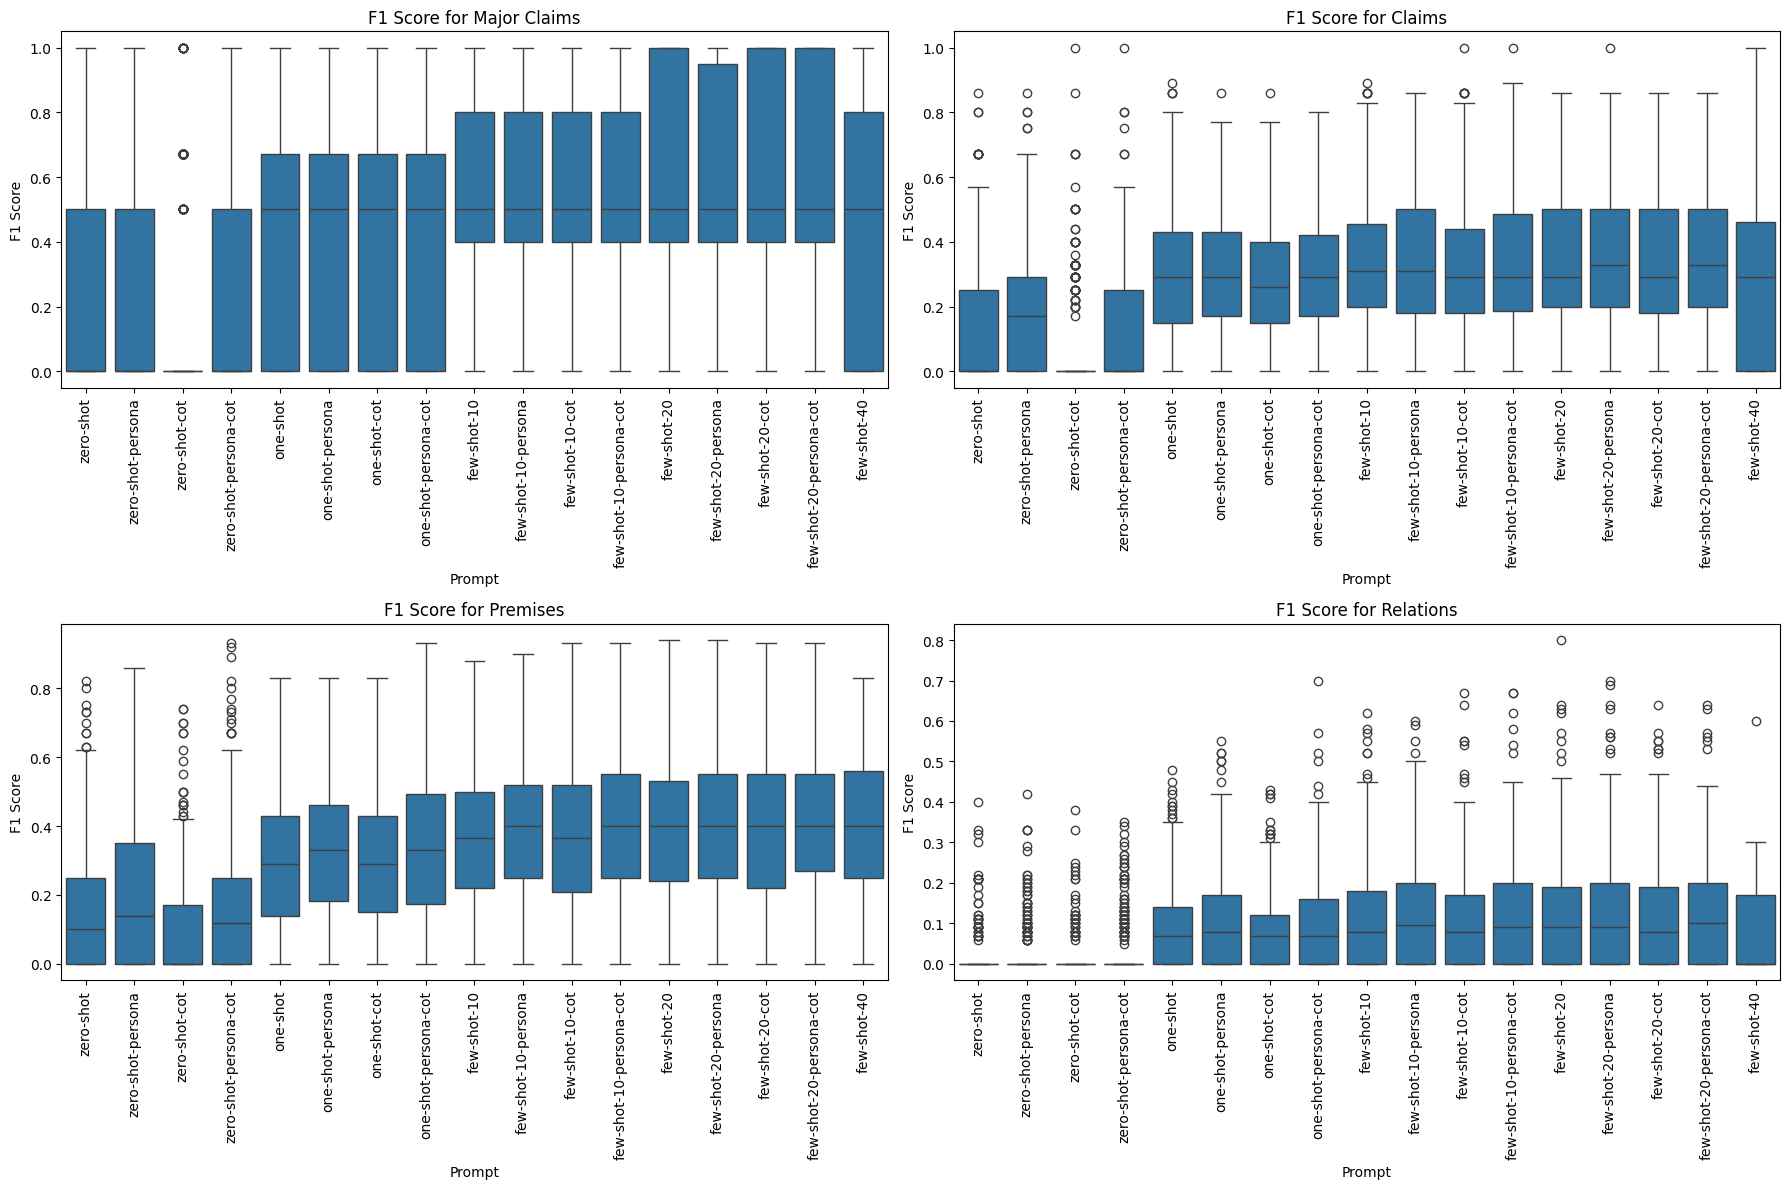

In [47]:
# Create 4 subplots as boxplots for MC, C, P, and R using eval_metric_df as data
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Boxplot for Major Claims (MC)
sns.boxplot(data=eval_metric_df, x='Prompt', y='F1_Score_MC', ax=axes[0, 0])
axes[0, 0].set_title('F1 Score for Major Claims')
axes[0, 0].set_xlabel('Prompt')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].tick_params(axis='x', rotation=90)

# Boxplot for Claims (C)
sns.boxplot(data=eval_metric_df, x='Prompt', y='F1_Score_C', ax=axes[0, 1])
axes[0, 1].set_title('F1 Score for Claims')
axes[0, 1].set_xlabel('Prompt')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].tick_params(axis='x', rotation=90)

# Boxplot for Premises (P)
sns.boxplot(data=eval_metric_df, x='Prompt', y='F1_Score_P', ax=axes[1, 0])
axes[1, 0].set_title('F1 Score for Premises')
axes[1, 0].set_xlabel('Prompt')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].tick_params(axis='x', rotation=90)

# Boxplot for Relations (R)
sns.boxplot(data=eval_metric_df, x='Prompt', y='F1_Score_R', ax=axes[1, 1])
axes[1, 1].set_title('F1 Score for Relations')
axes[1, 1].set_xlabel('Prompt')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## Kennzahl F1-Score pro Token bestimmen